Simulation of numerical approximation of diffusion equation  with plug and Gaussian inputs, illustrating spatial and temporal evolution of concentration profiles.

Printing the exact solution of the diffusion equation
[0.         0.4410126  0.86402469 1.26903626 1.65604731 2.02505786
 2.37606789 2.7090774  3.0240864  3.32109489 3.60010286 3.86111031
 4.10411726 4.32912369 4.5361296  4.725135   4.89613989 5.04914426
 5.18414811 5.30115146 5.40015429 5.4811566  5.5441584  5.58915969
 5.61616046 5.62516071 5.61616046 5.58915969 5.5441584  5.4811566
 5.40015429 5.30115146 5.18414811 5.04914426 4.89613989 4.725135
 4.5361296  4.32912369 4.10411726 3.86111031 3.60010286 3.32109489
 3.0240864  2.7090774  2.37606789 2.02505786 1.65604731 1.26903626
 0.86402469 0.4410126  0.        ]
*****************************************************
Printing the constructed numerical solution of the diffusion equation
[0.         0.44098425 0.86396914 1.26895468 1.65594086 2.02492768
 2.37591514 2.70890325 3.023892   3.32088139 3.59987143 3.86086211
 4.10385343 4.32884539 4.535838   4.72483125 4.89582514 5.04881968
 5.18381486 5.30081068 5.39980714 5.48080425 5.543802

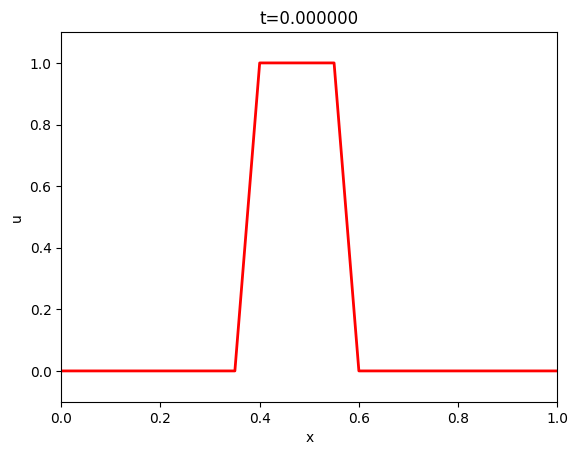

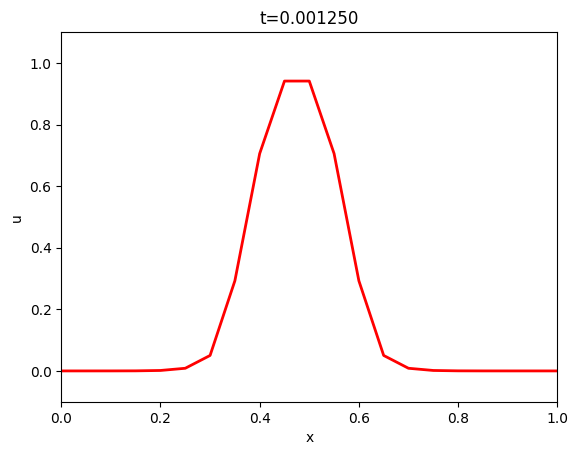

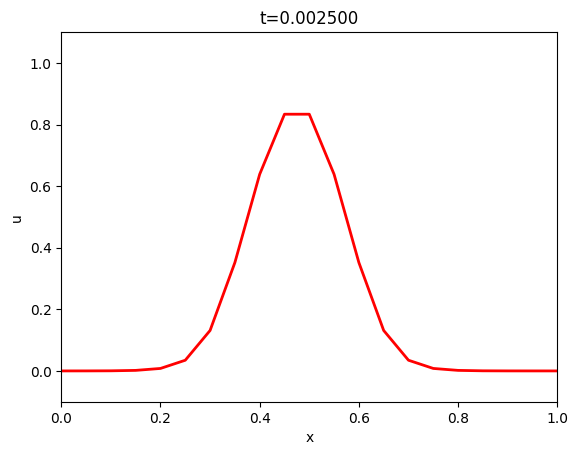

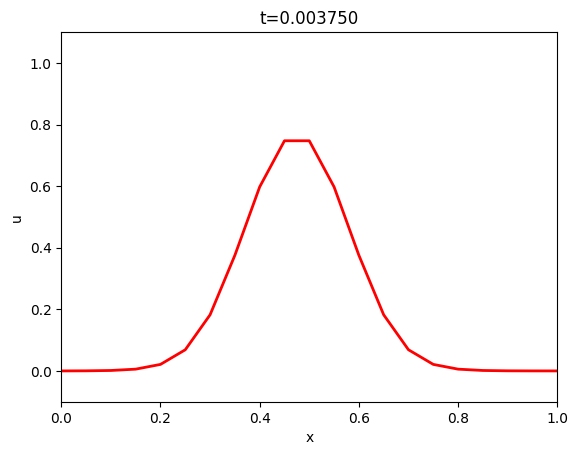

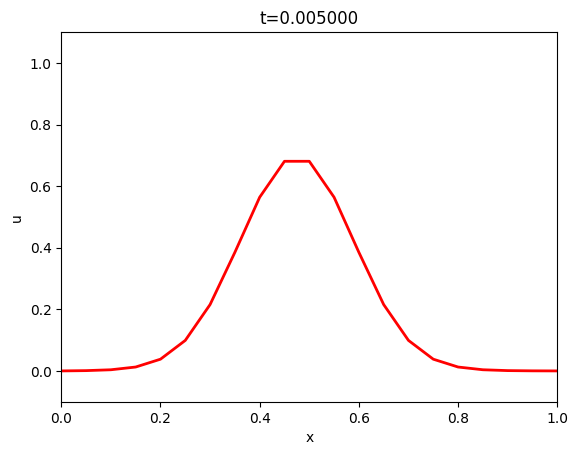

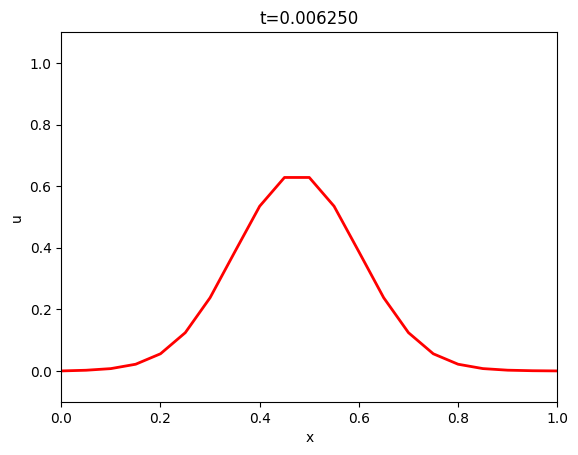

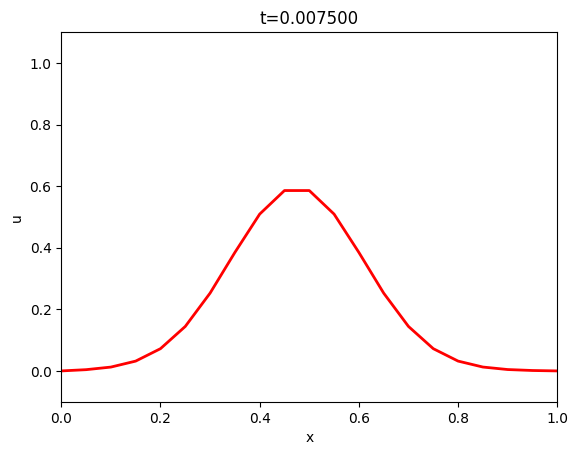

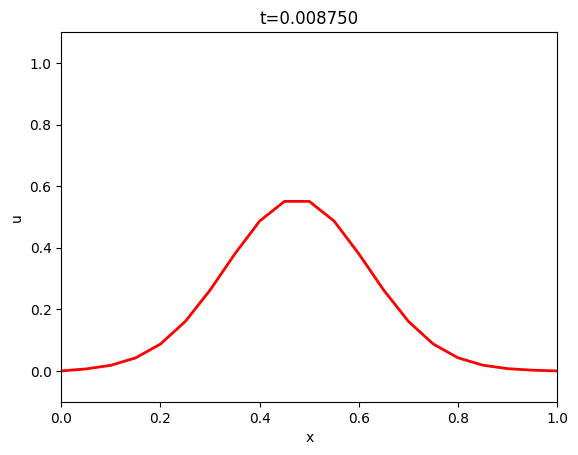

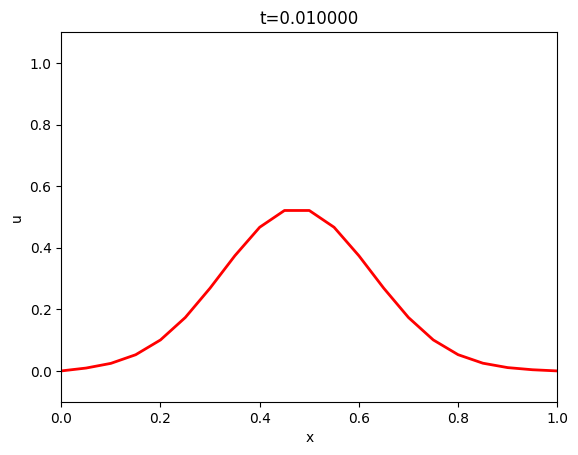

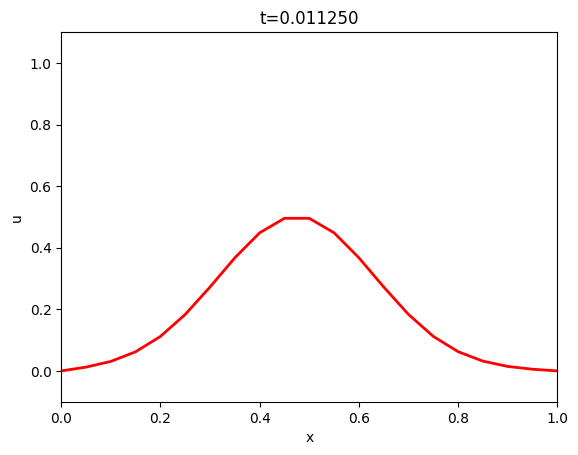

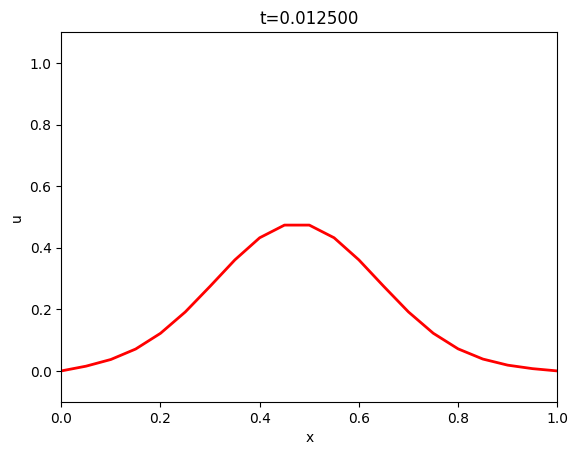

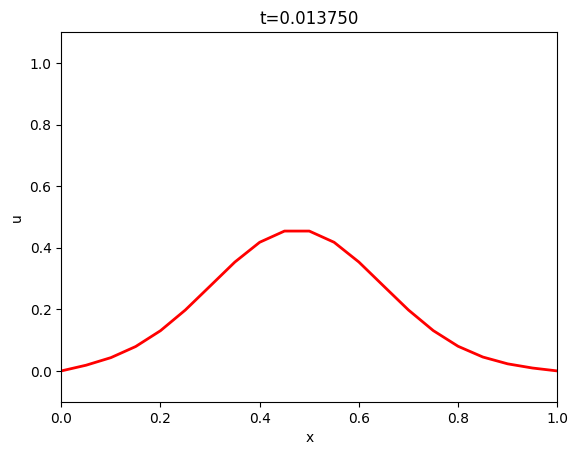

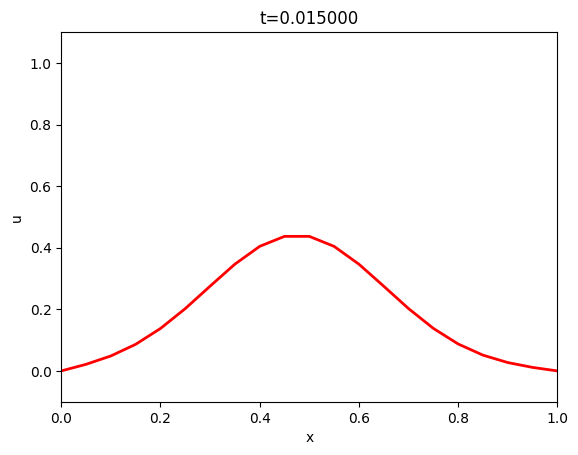

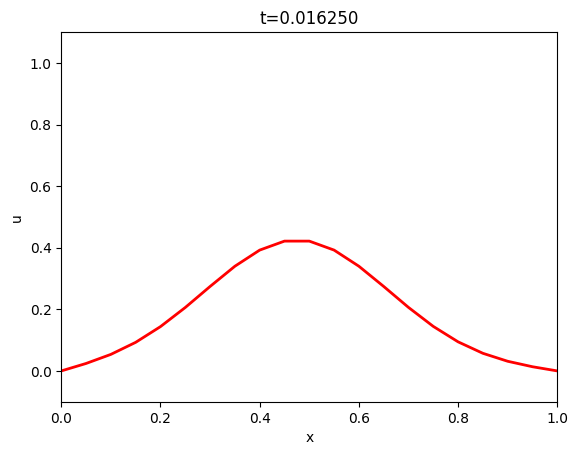

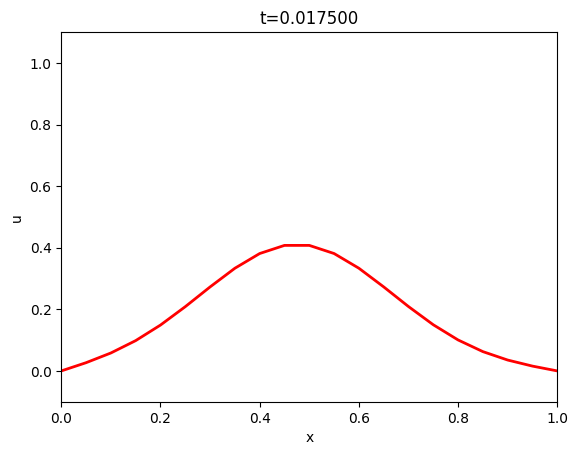

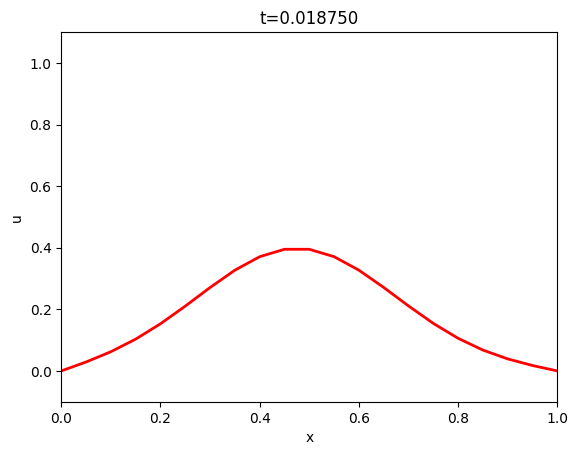

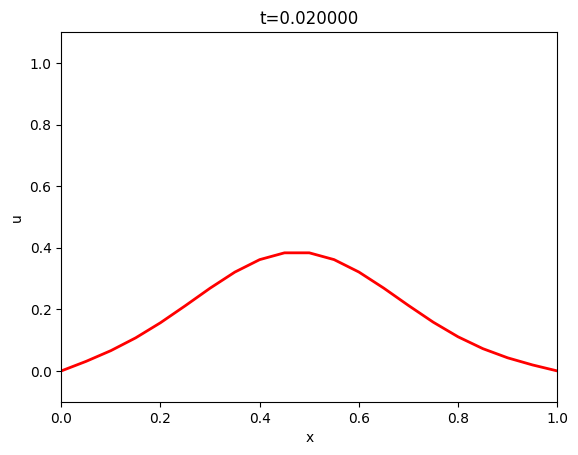

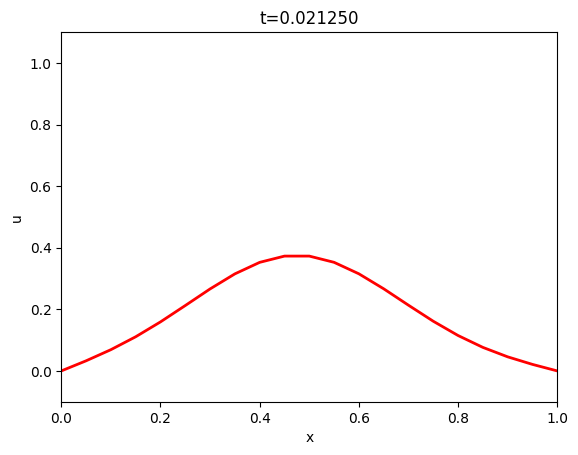

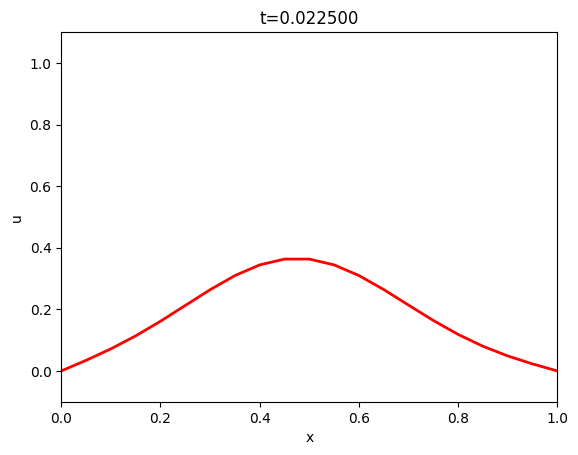

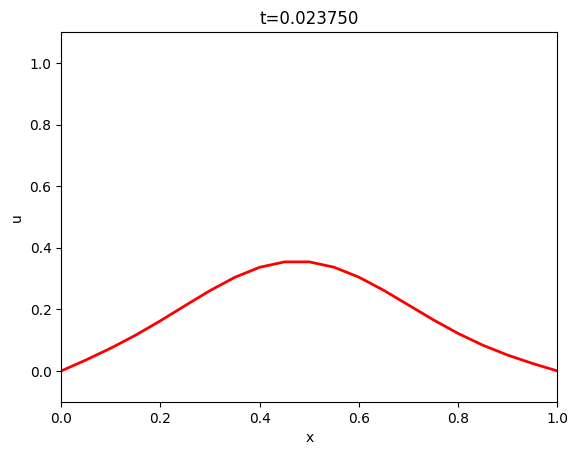

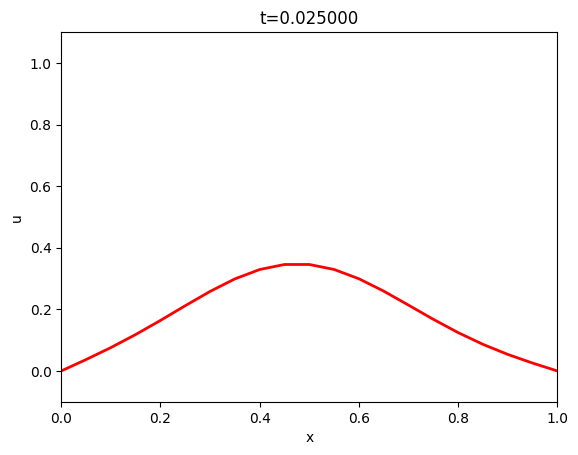

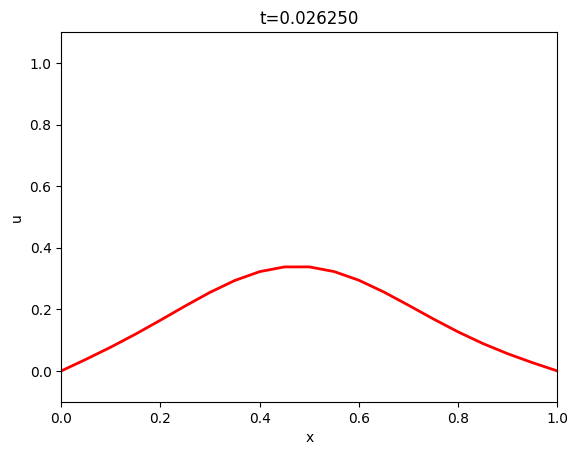

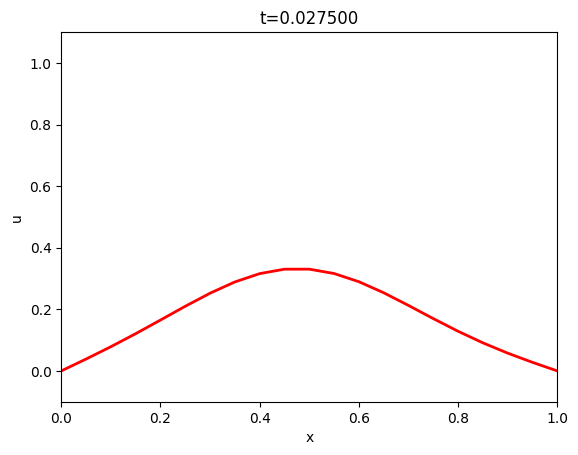

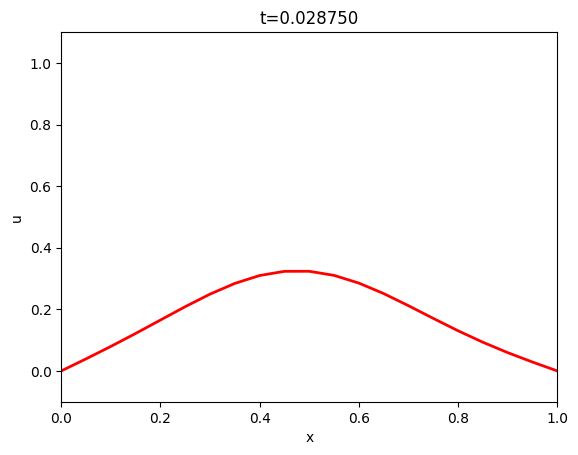

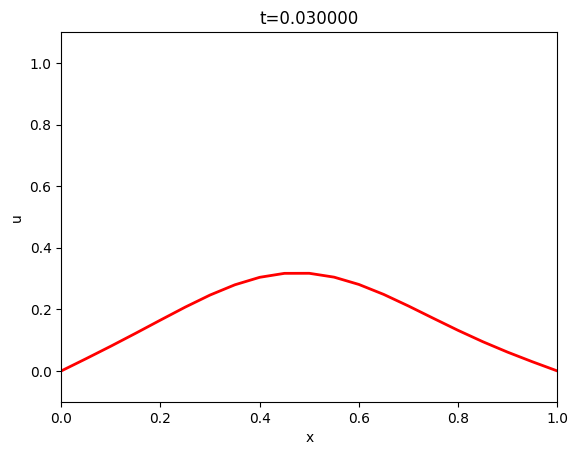

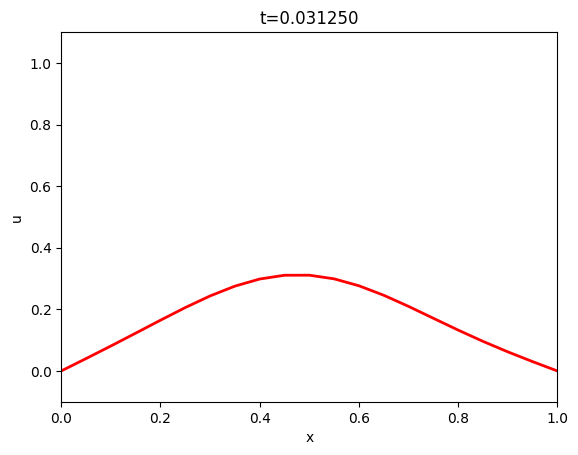

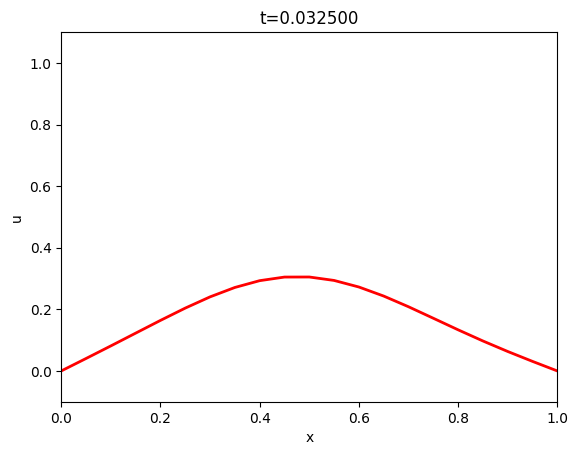

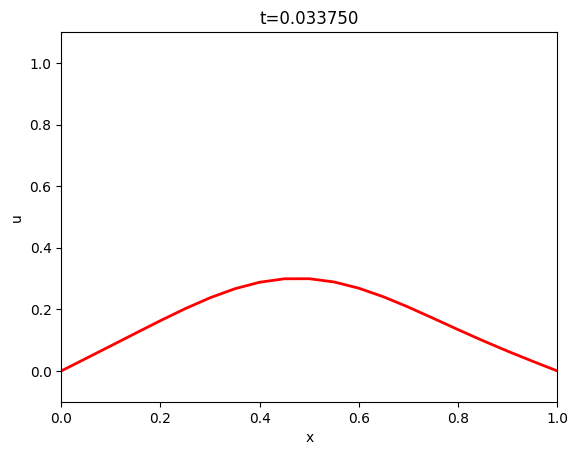

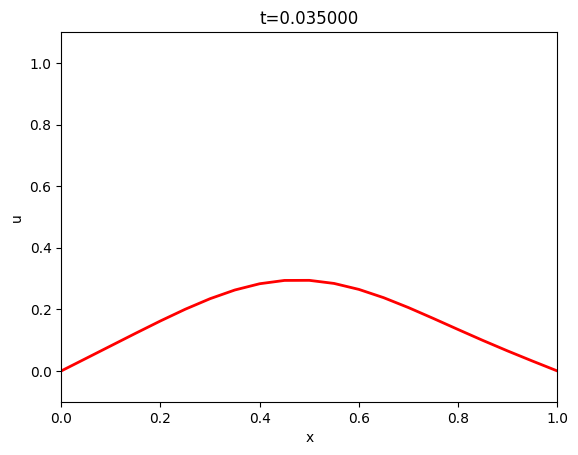

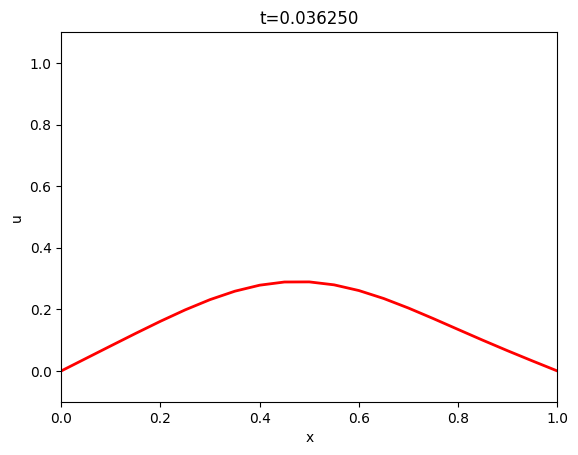

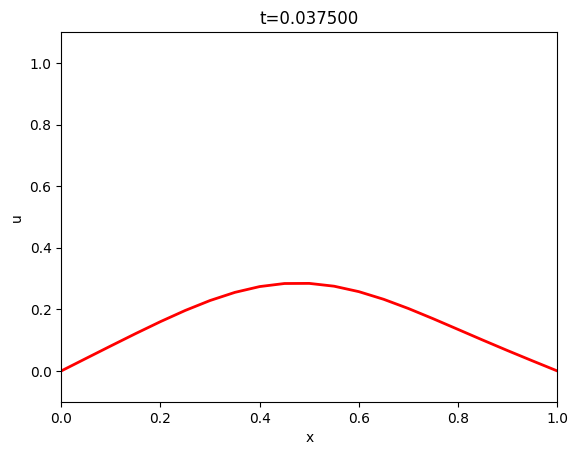

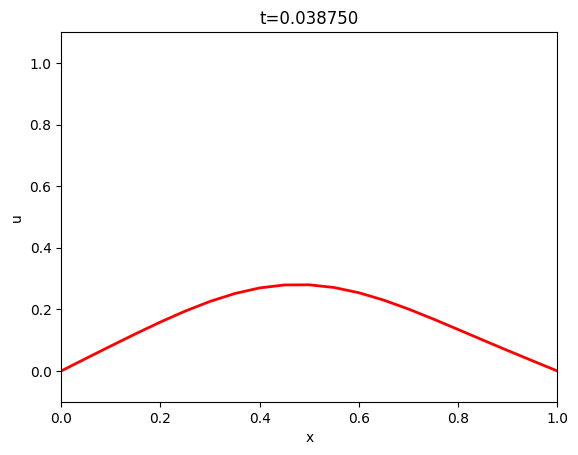

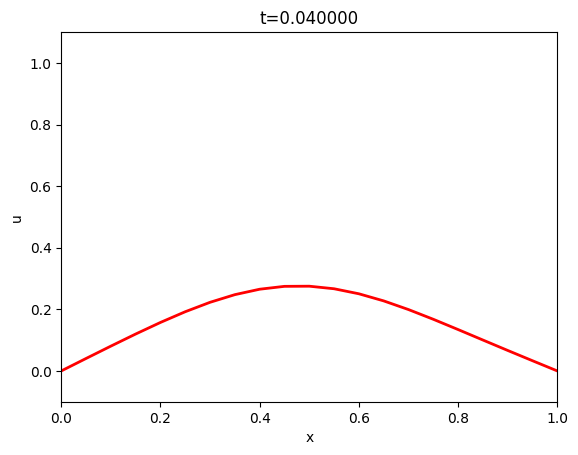

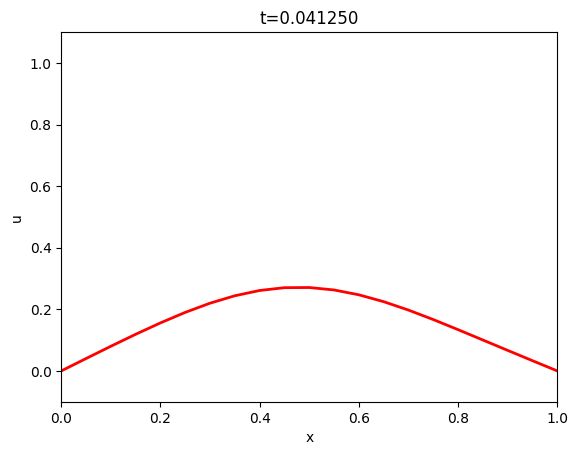

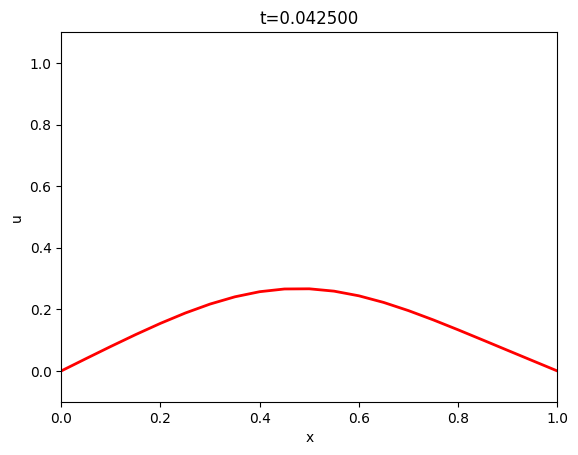

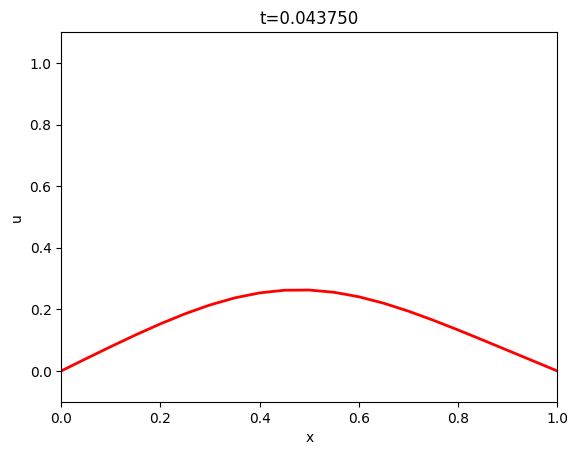

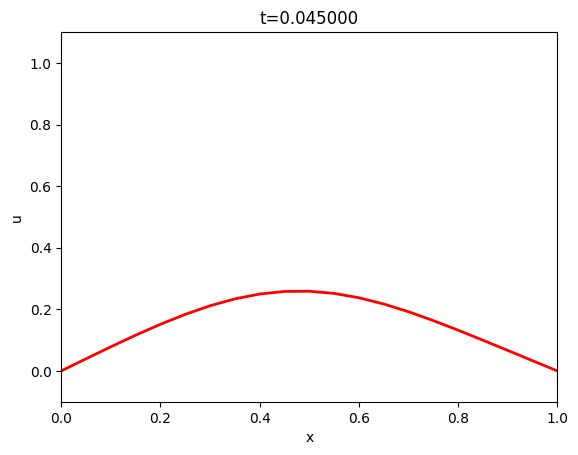

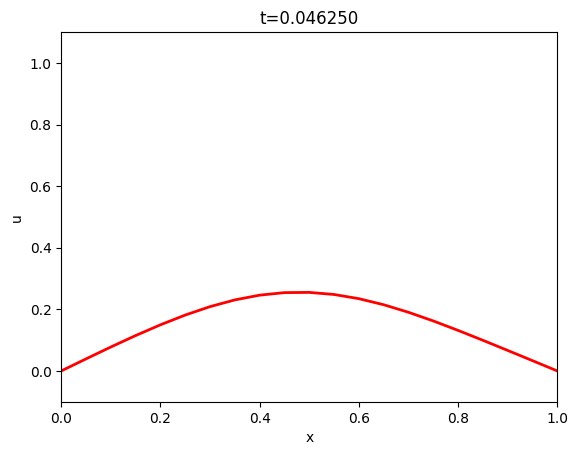

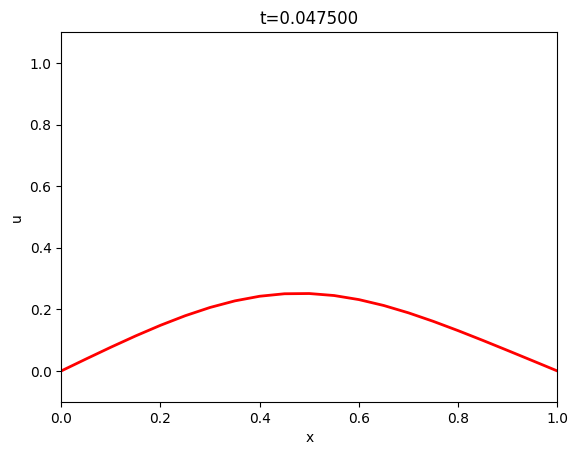

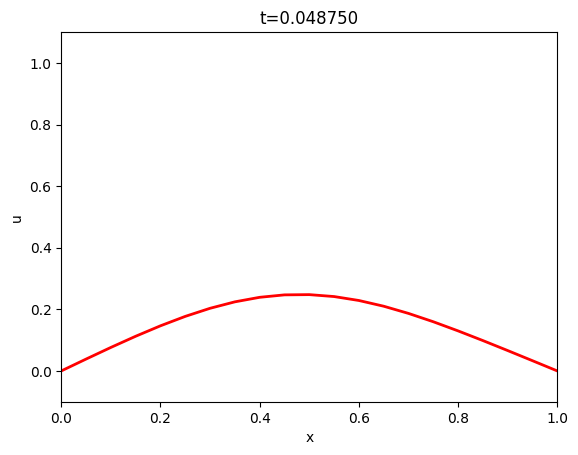

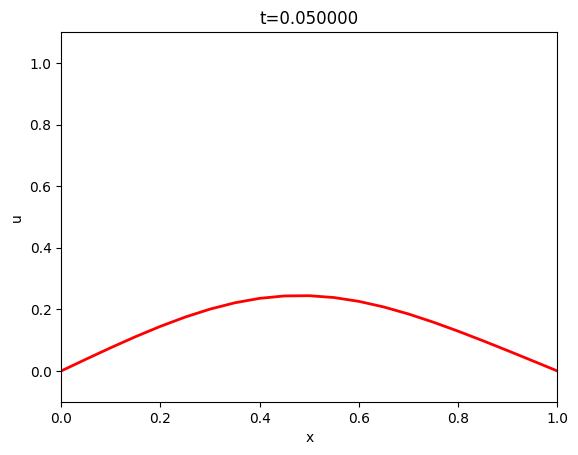

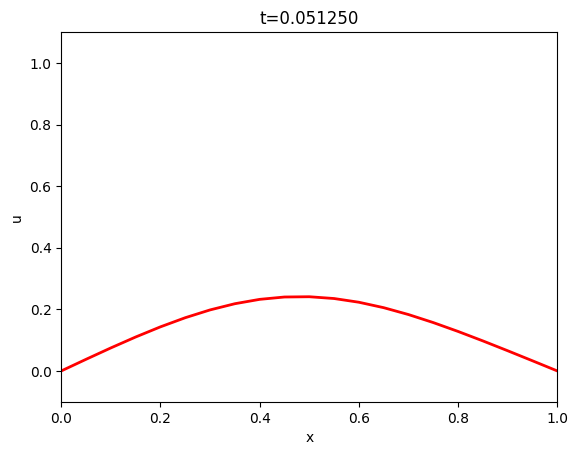

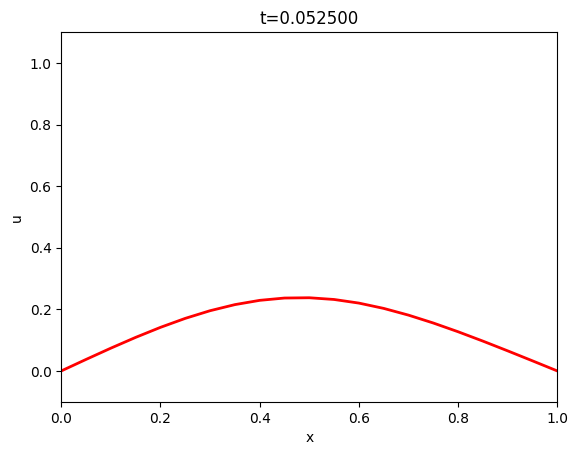

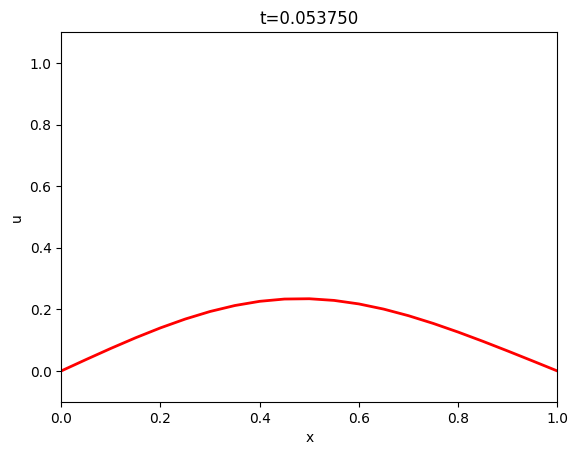

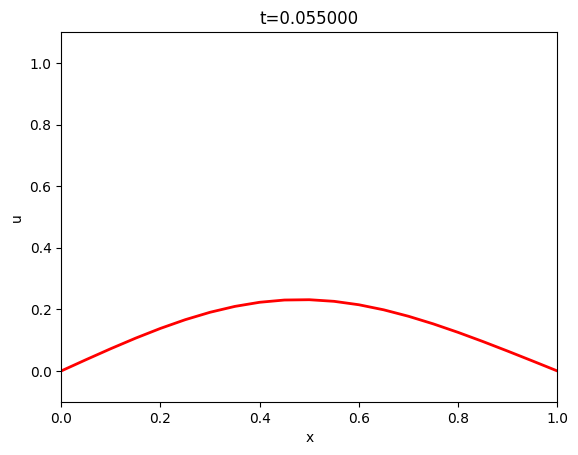

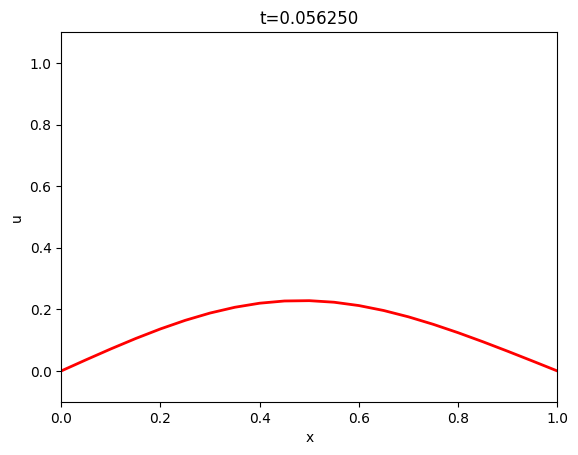

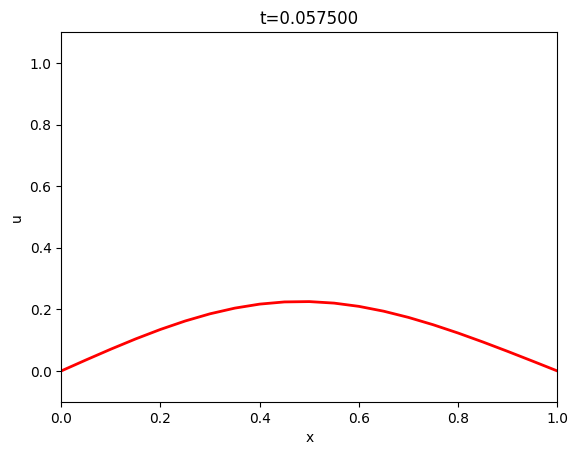

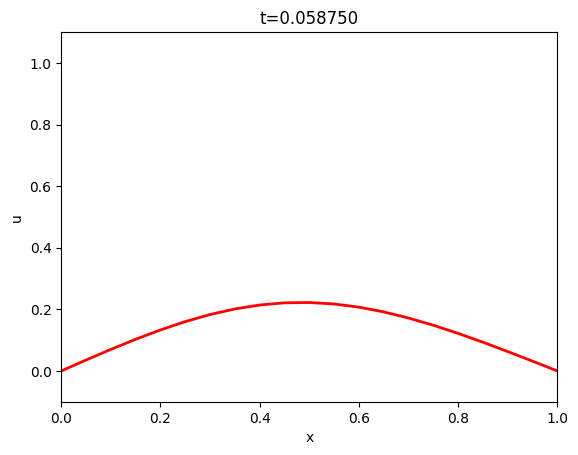

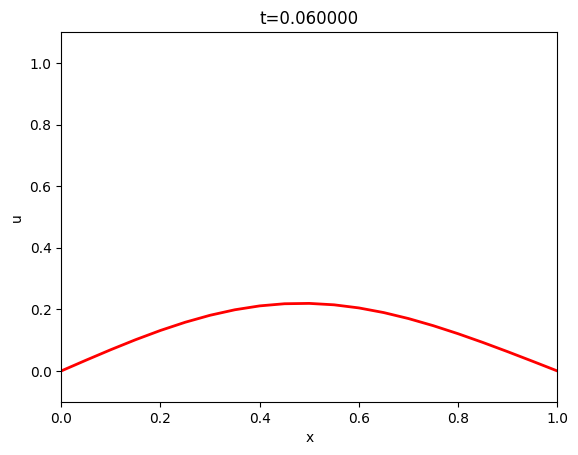

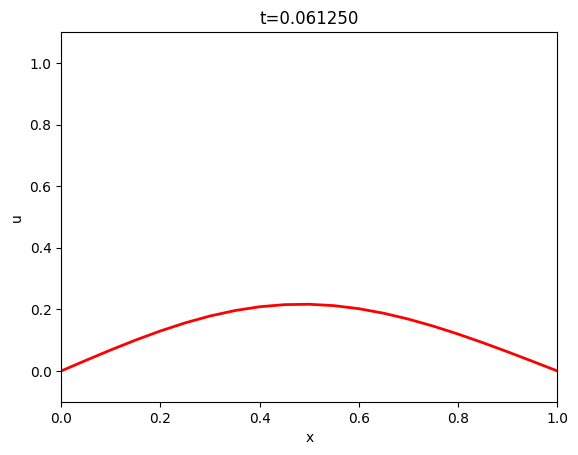

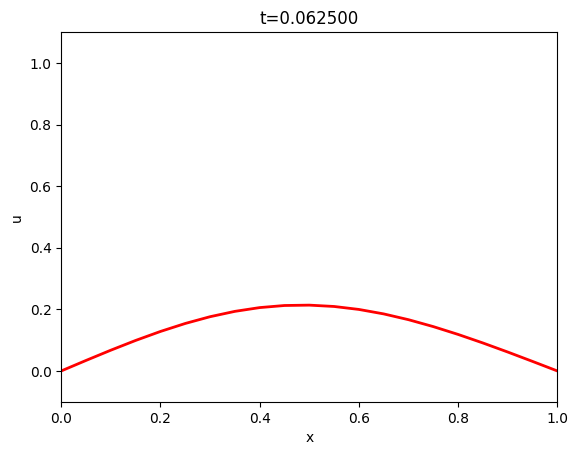

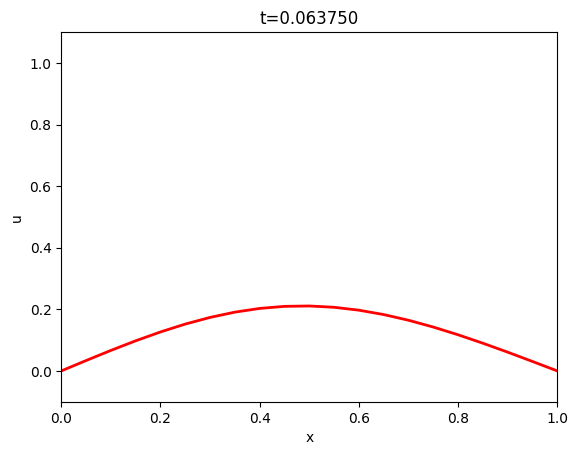

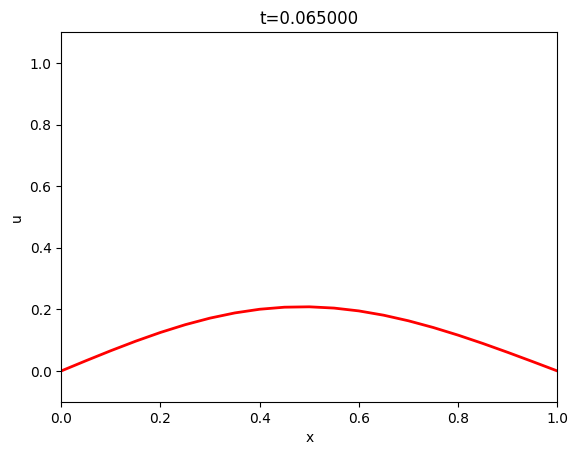

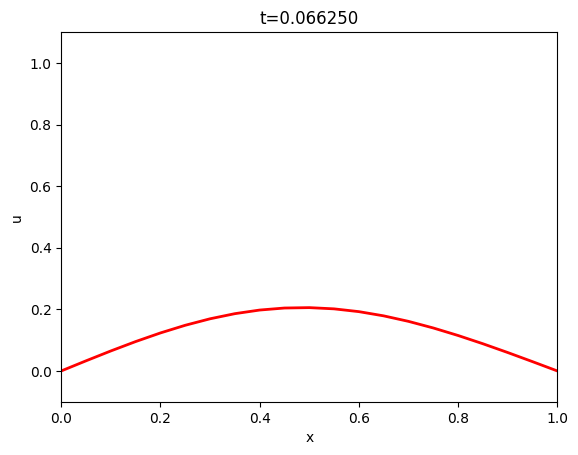

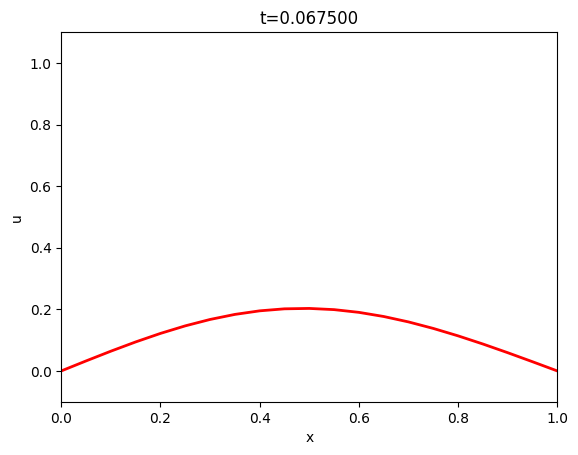

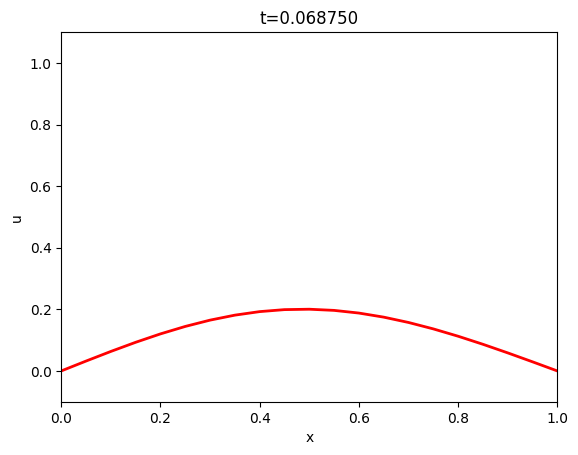

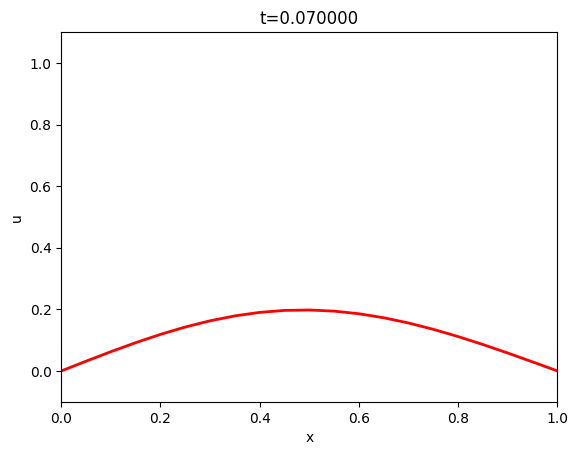

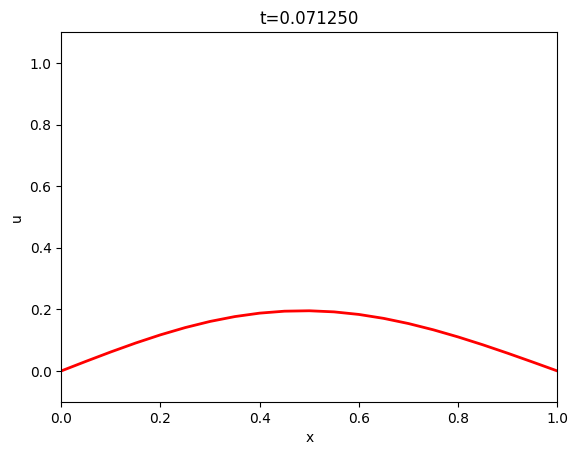

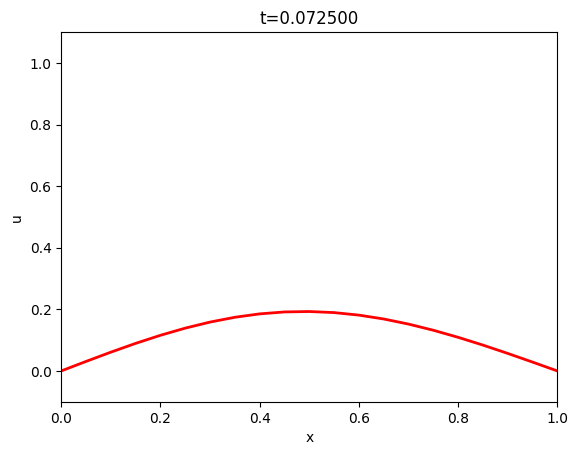

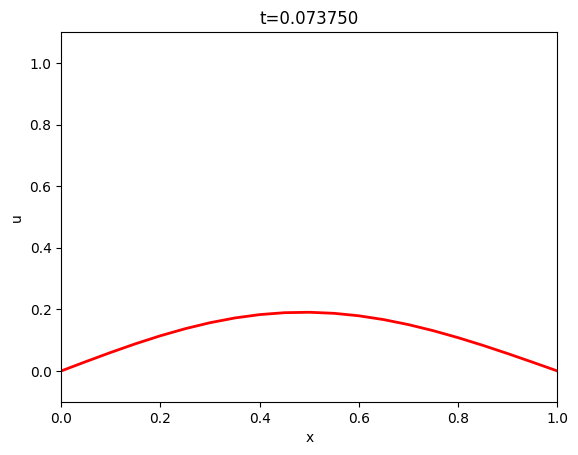

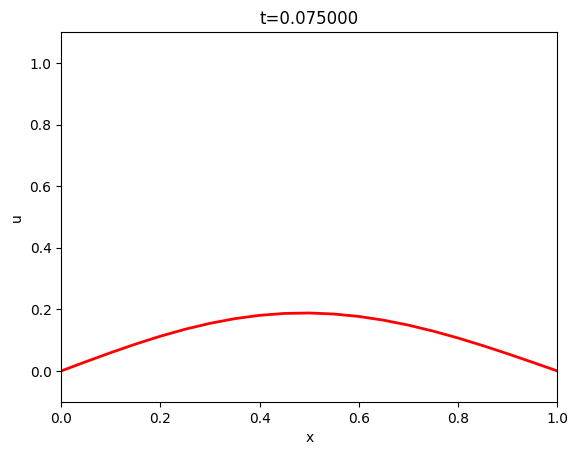

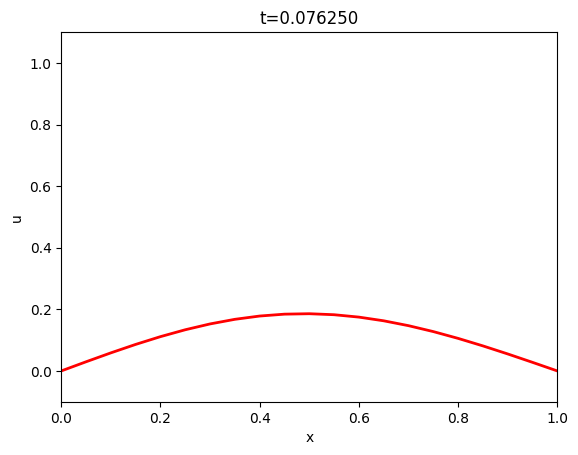

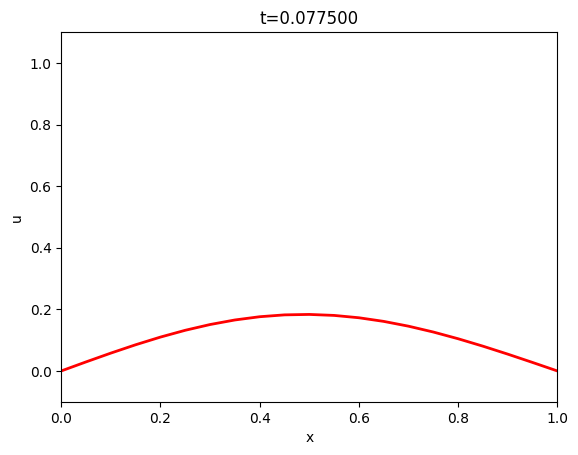

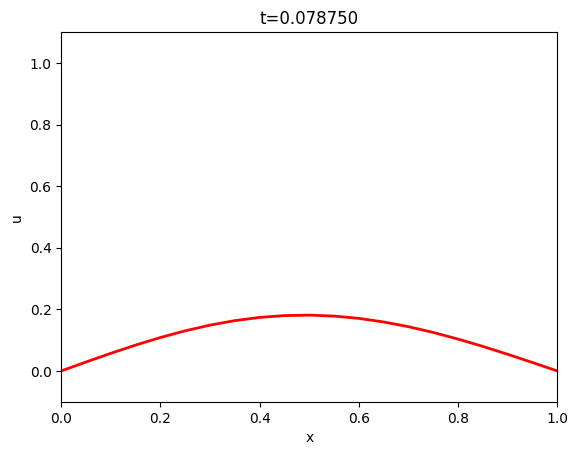

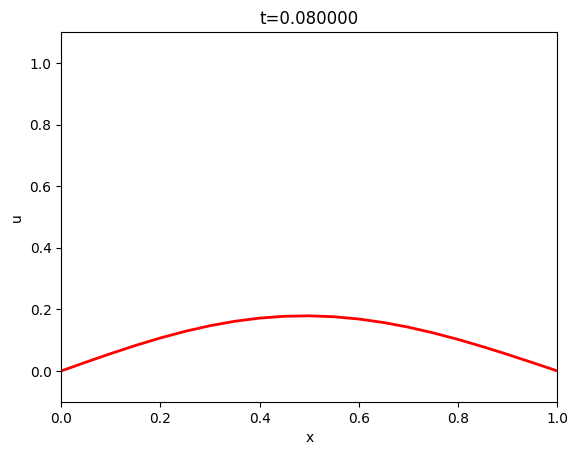

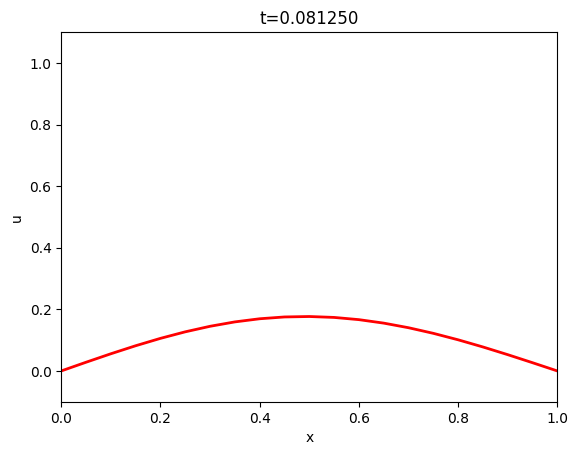

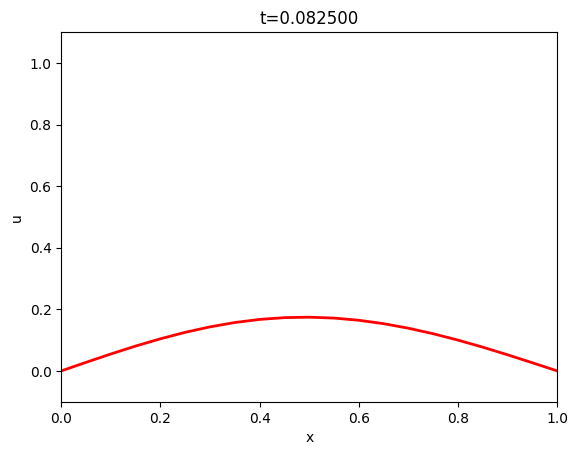

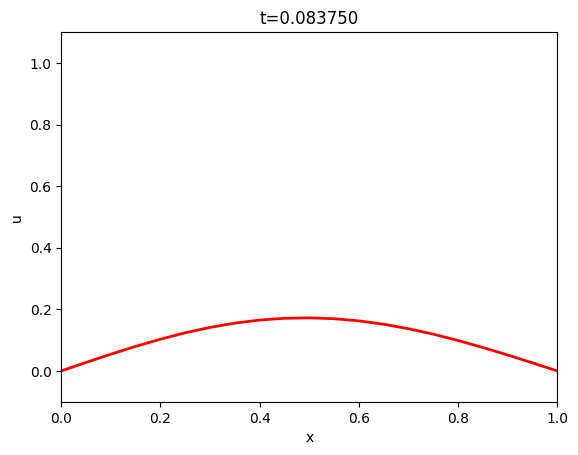

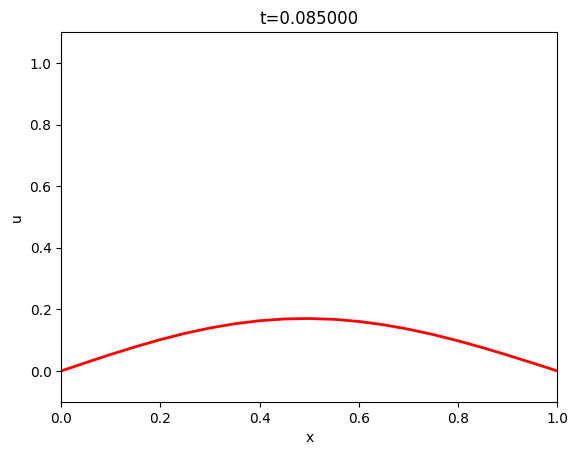

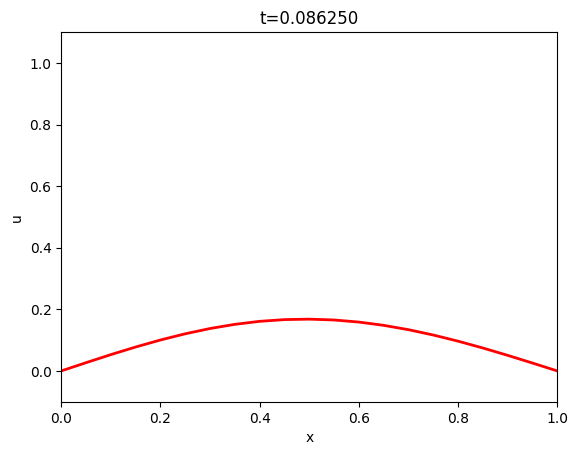

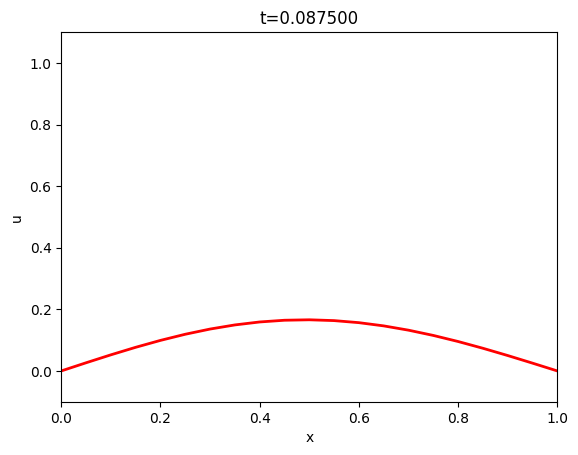

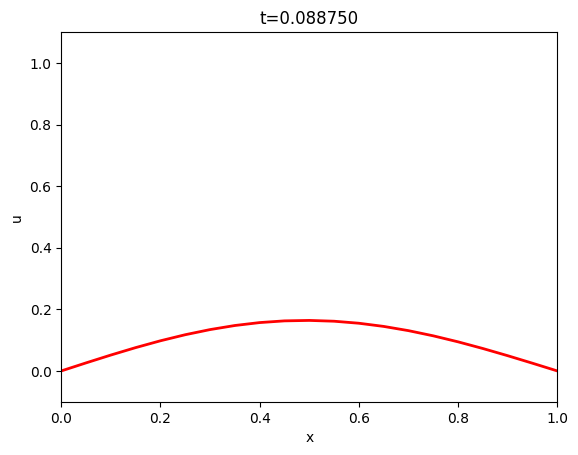

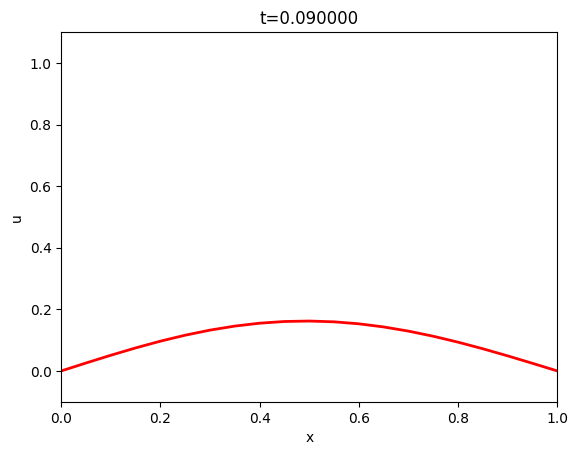

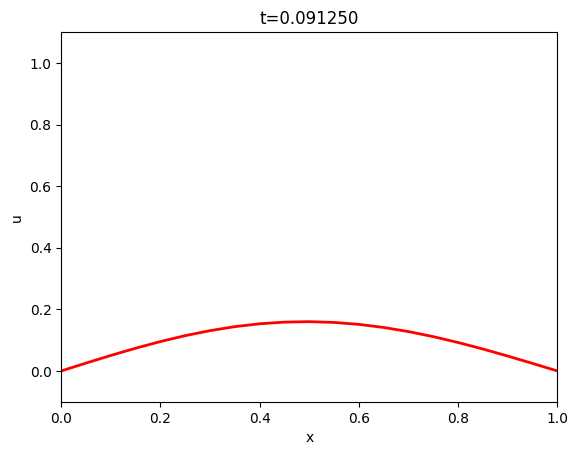

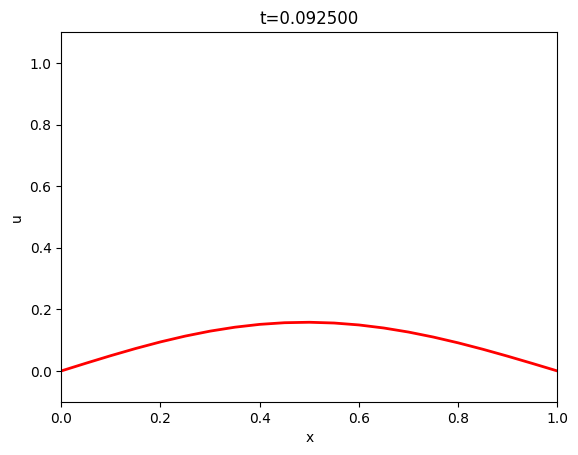

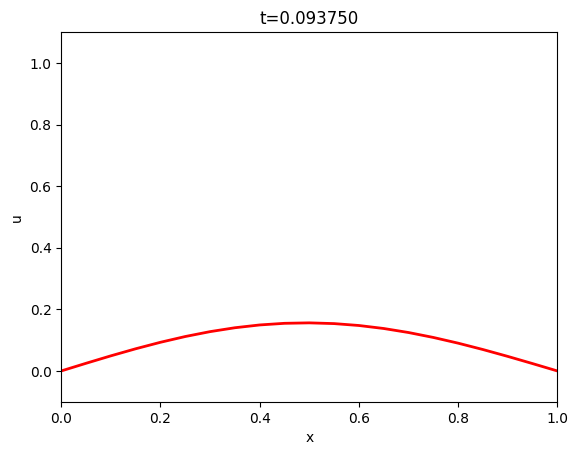

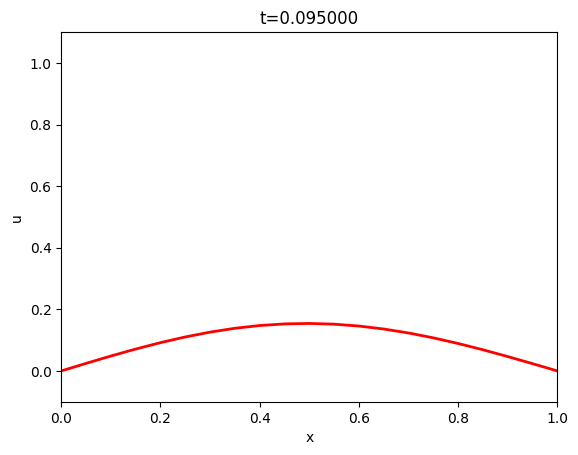

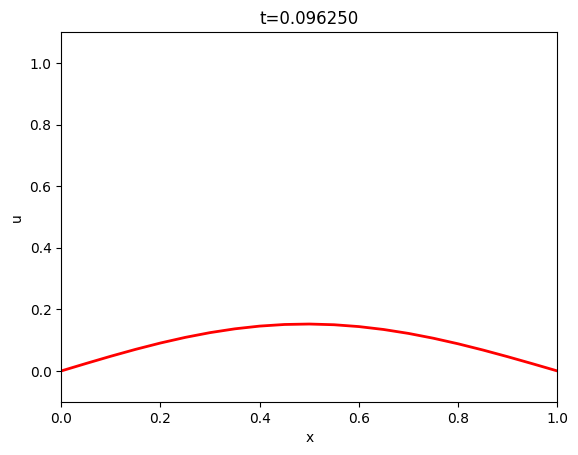

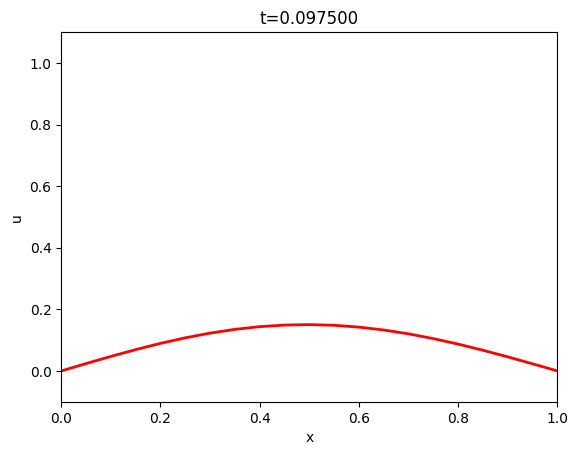

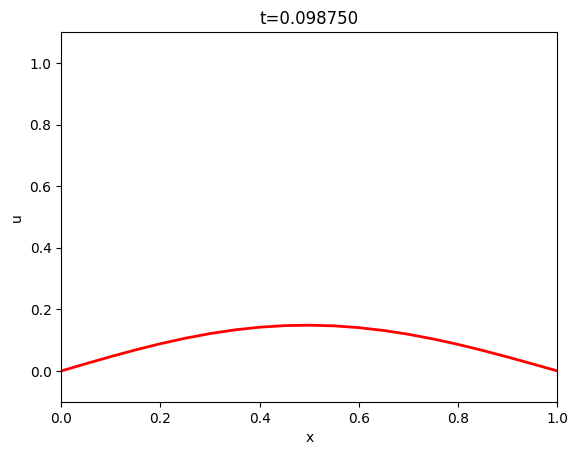

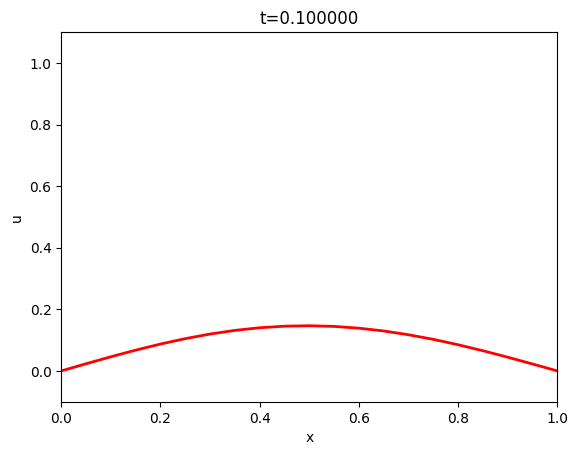


************************
------------------------
************************

For Gaussian input


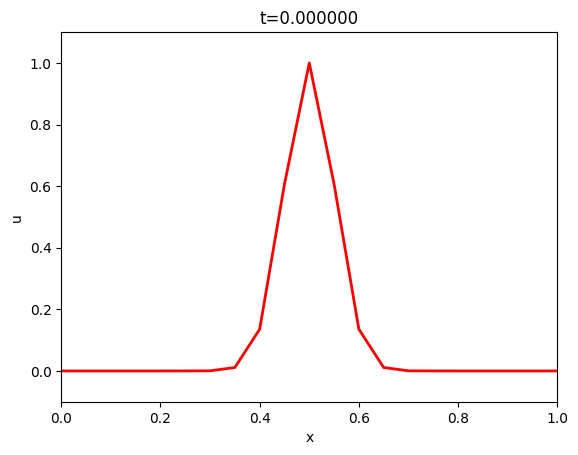

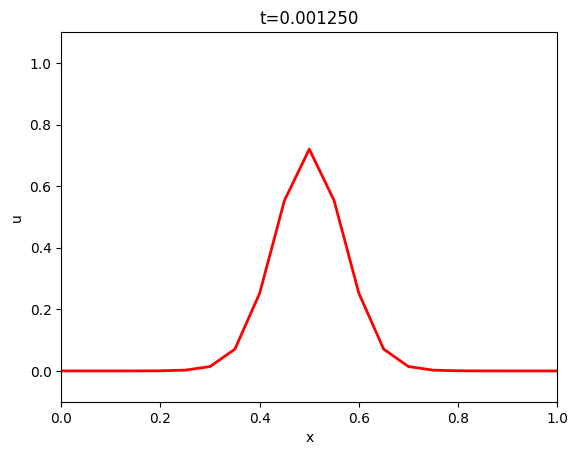

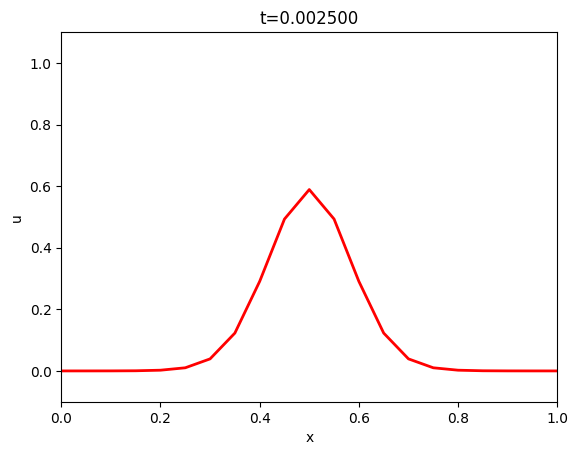

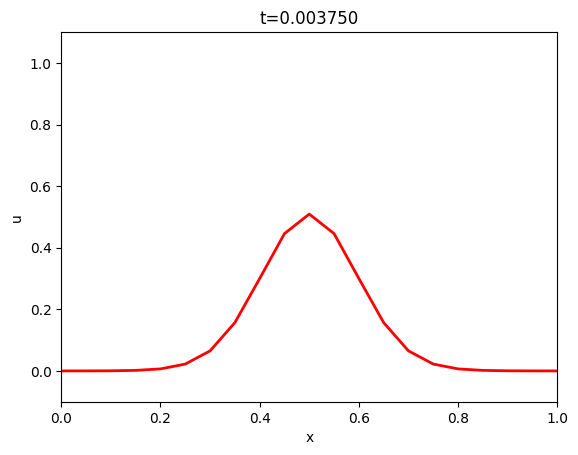

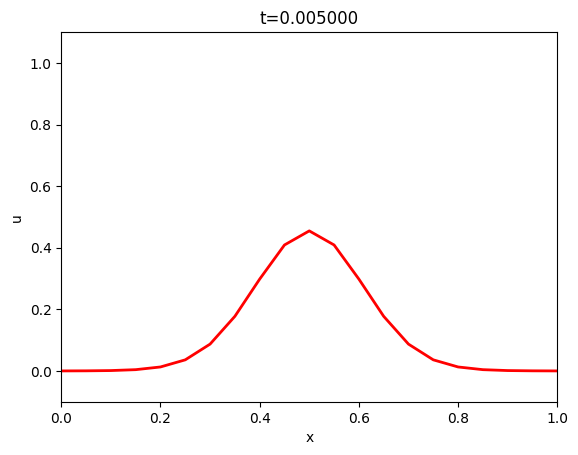

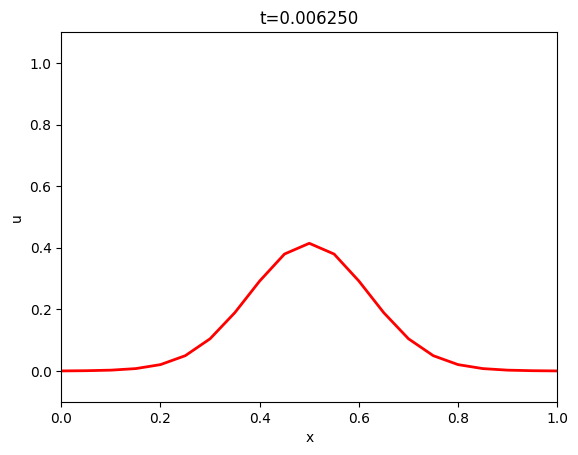

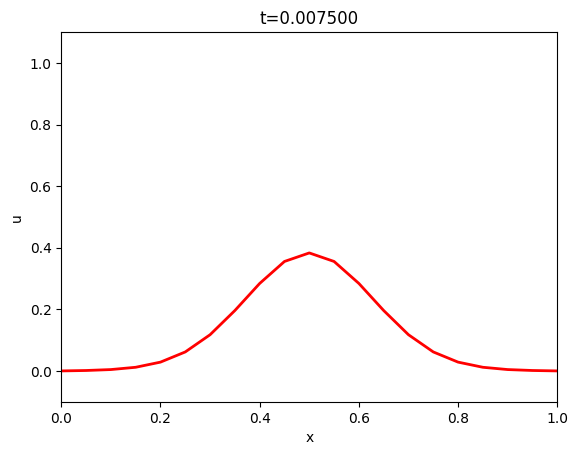

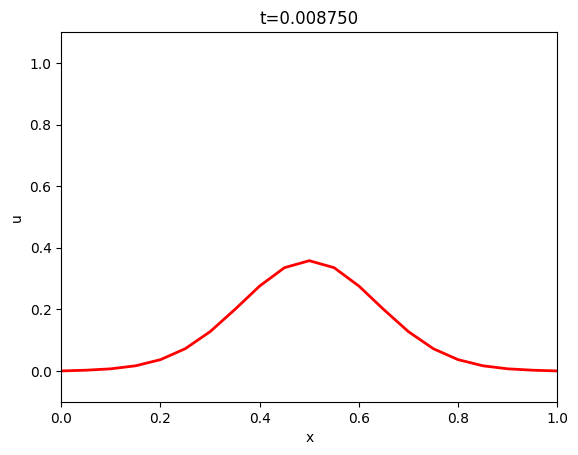

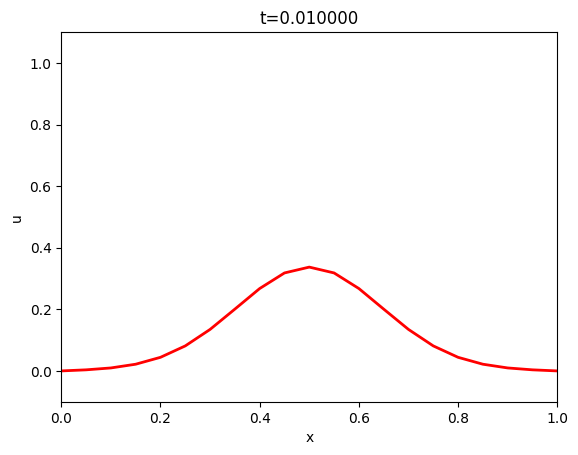

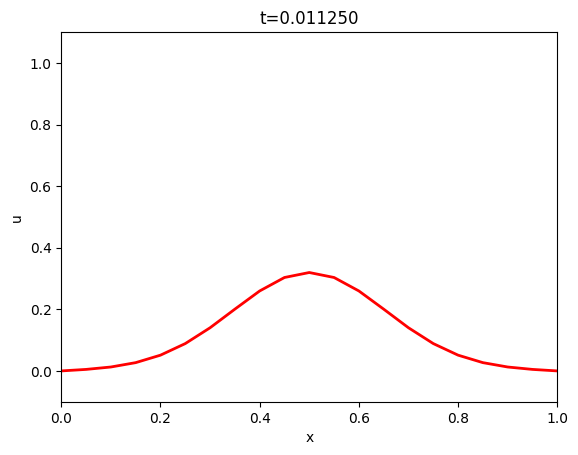

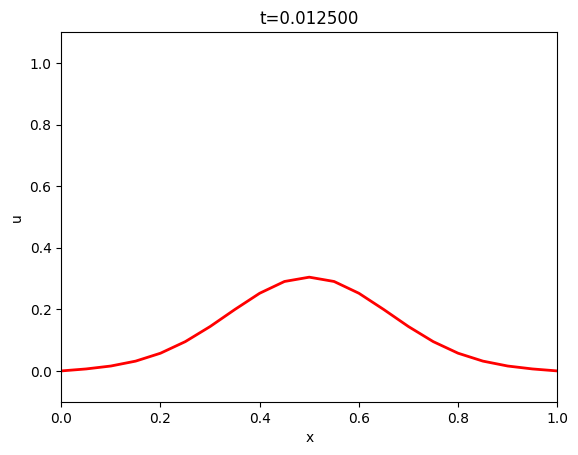

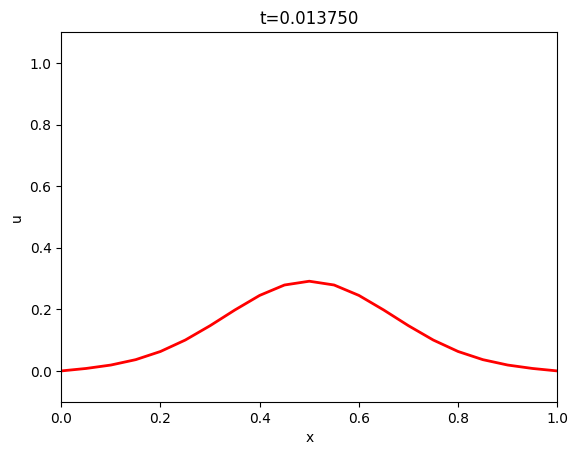

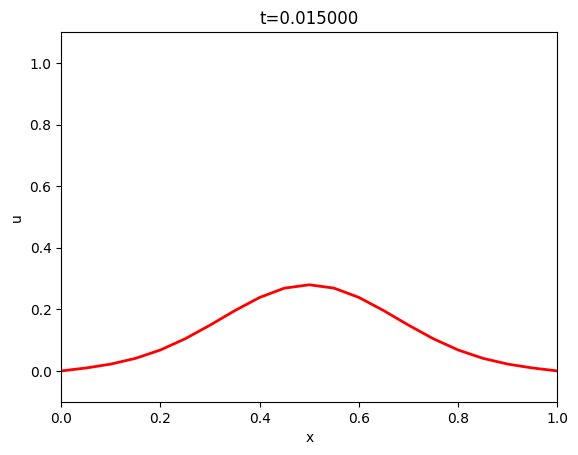

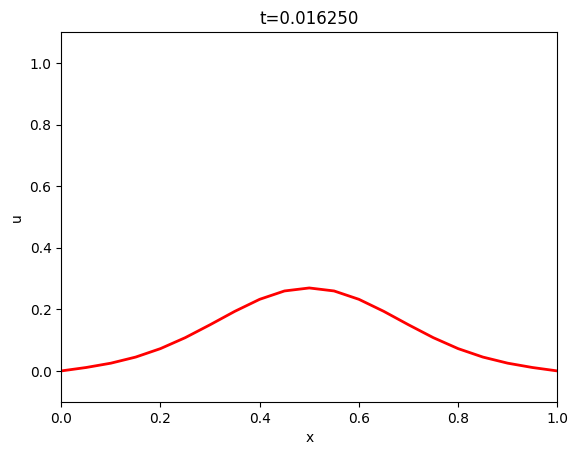

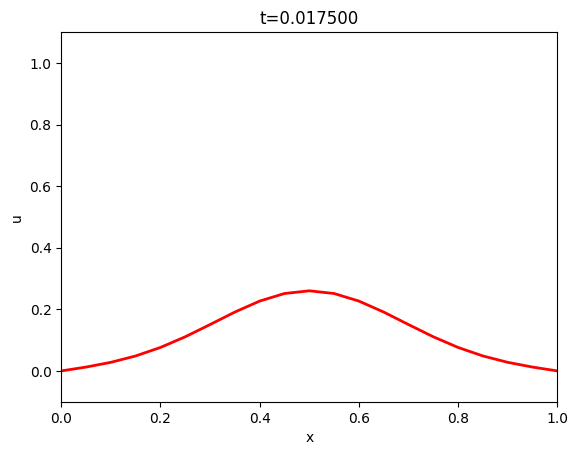

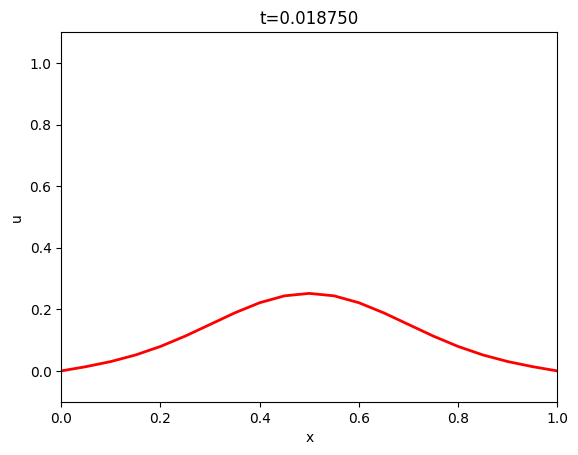

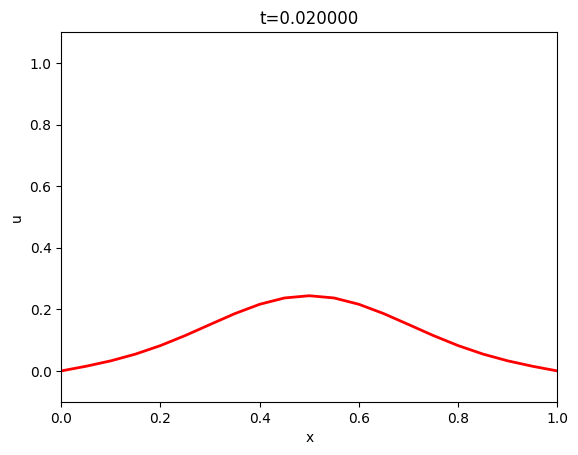

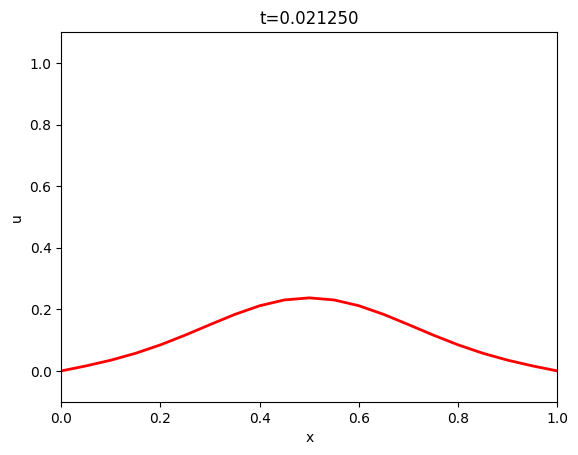

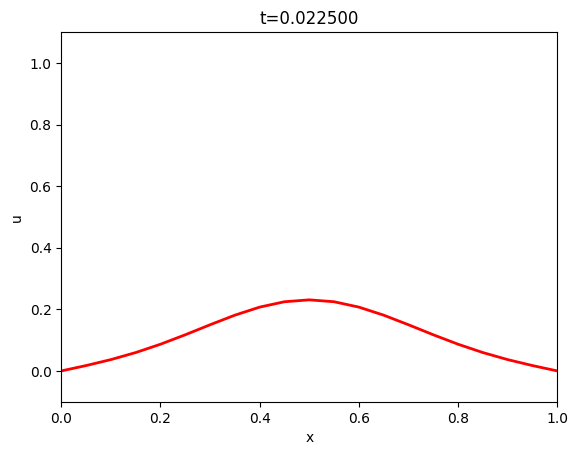

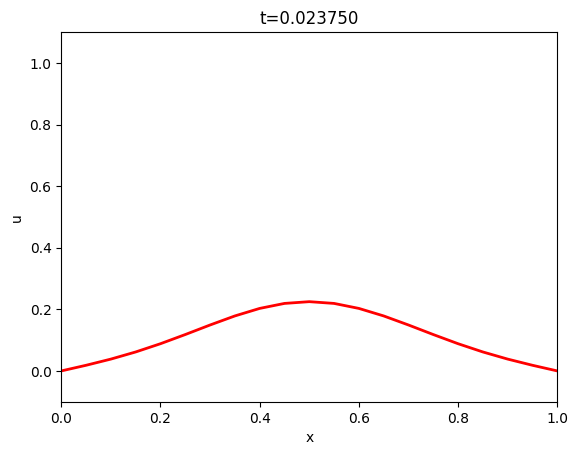

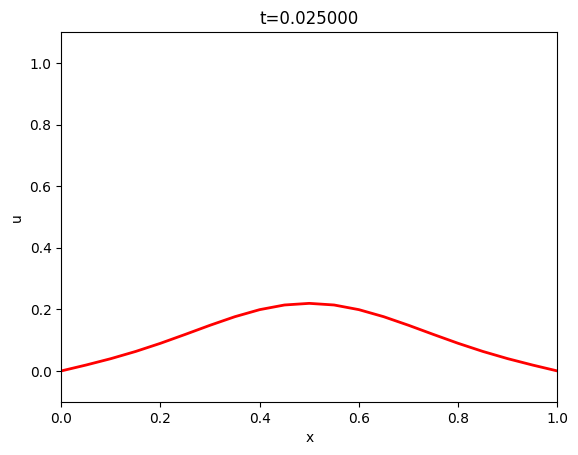

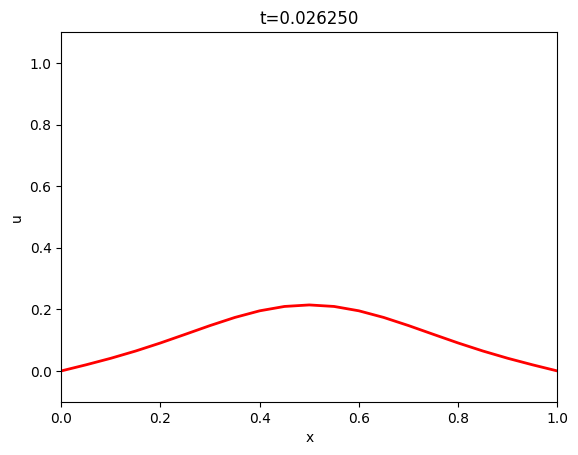

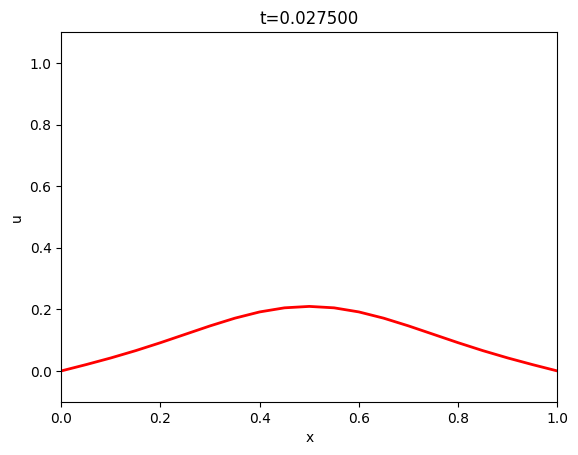

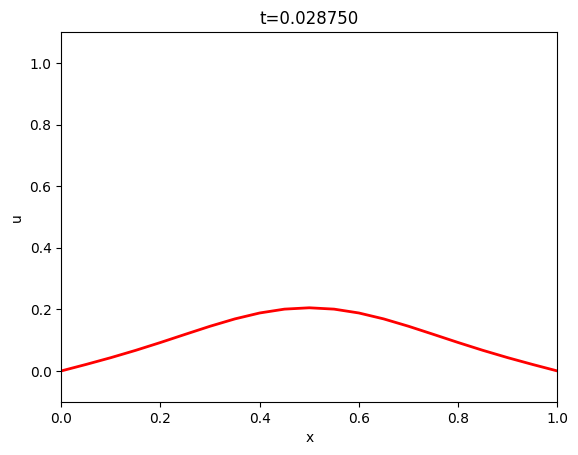

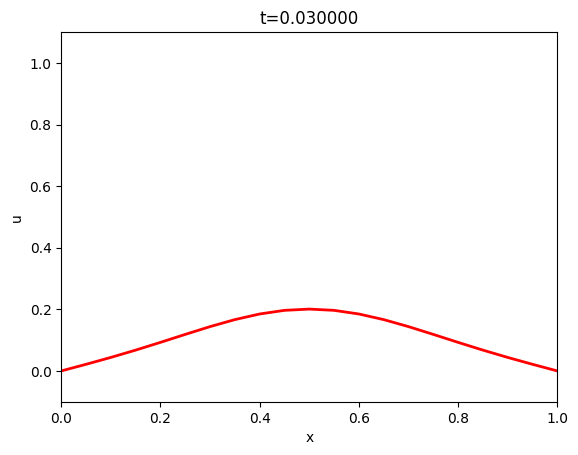

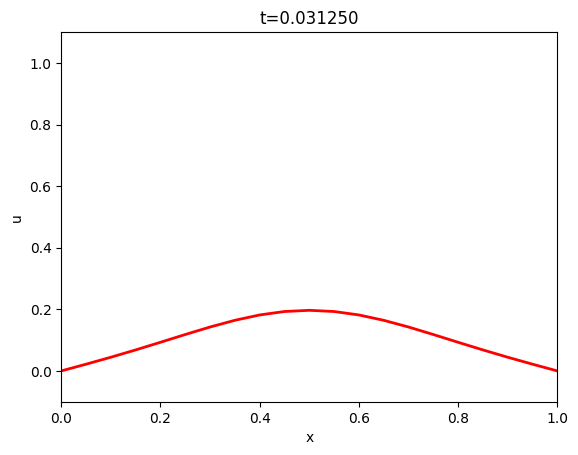

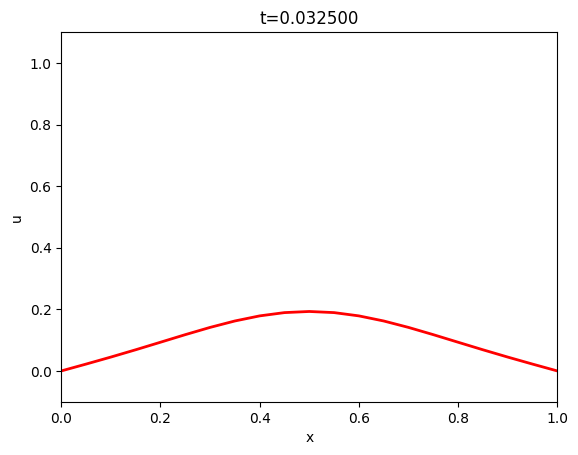

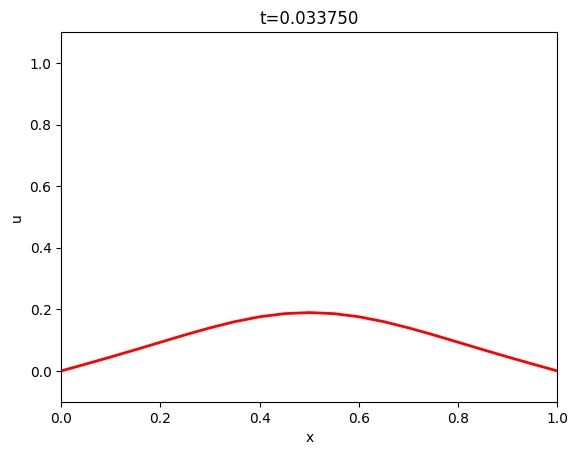

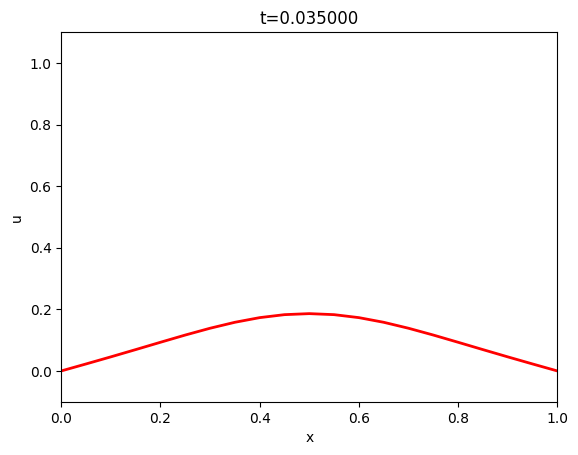

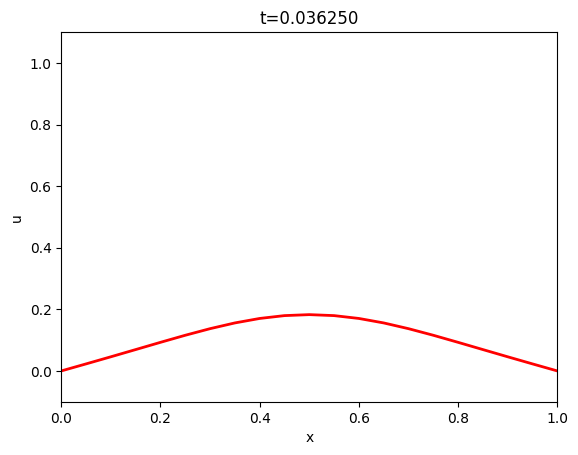

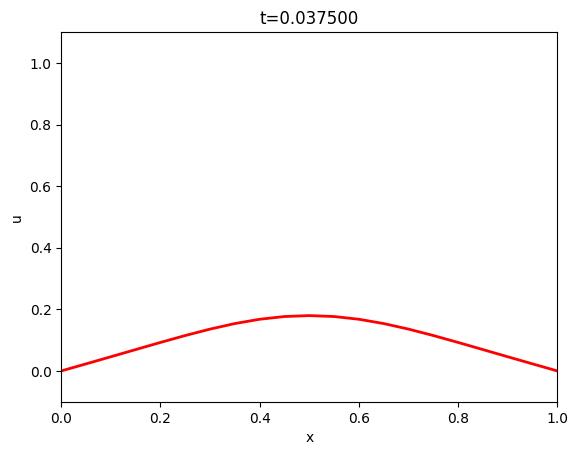

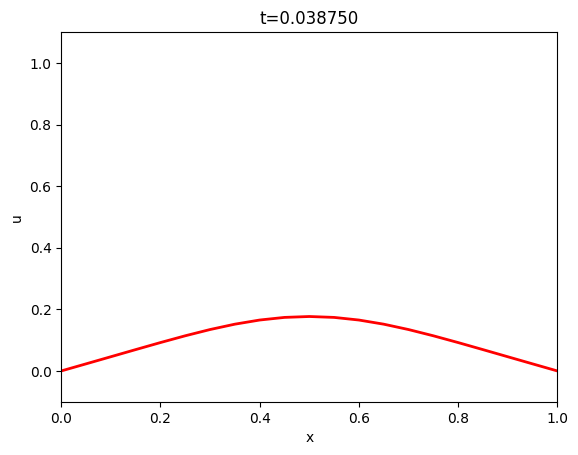

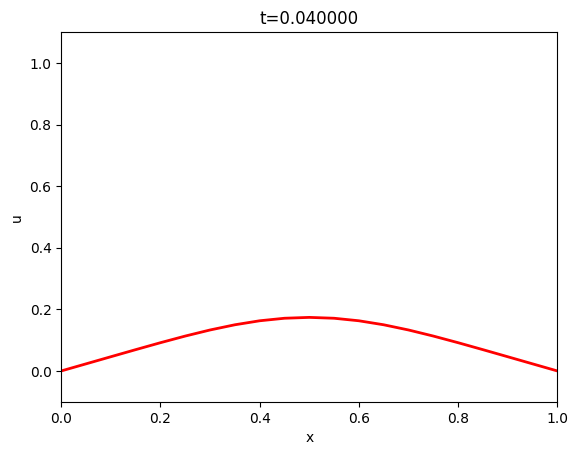

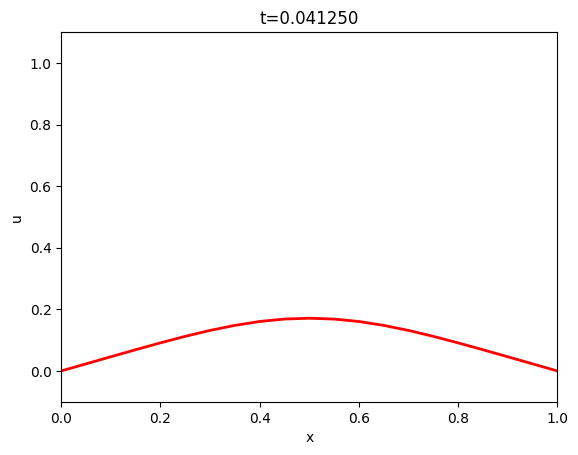

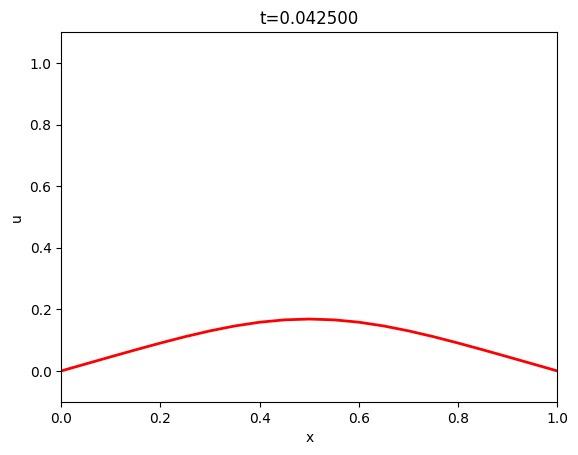

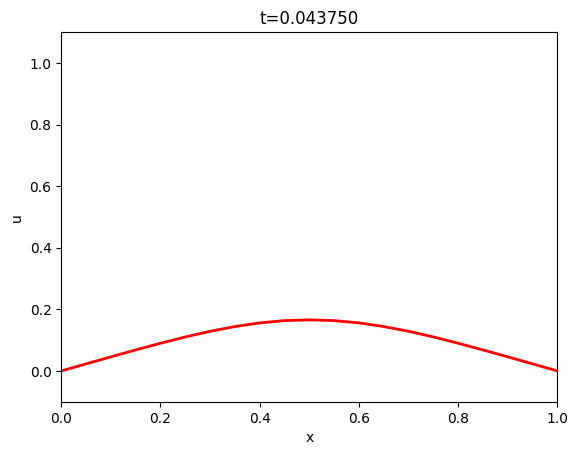

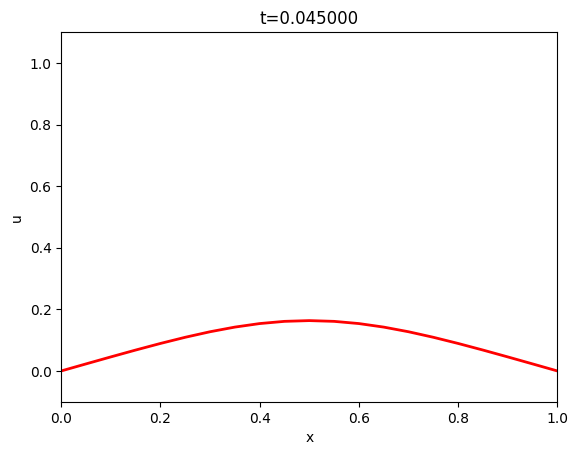

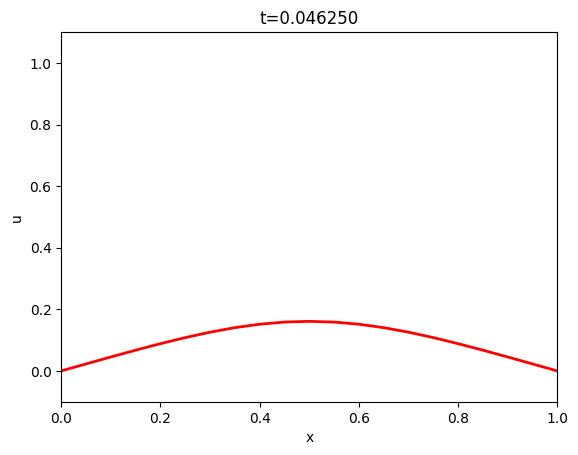

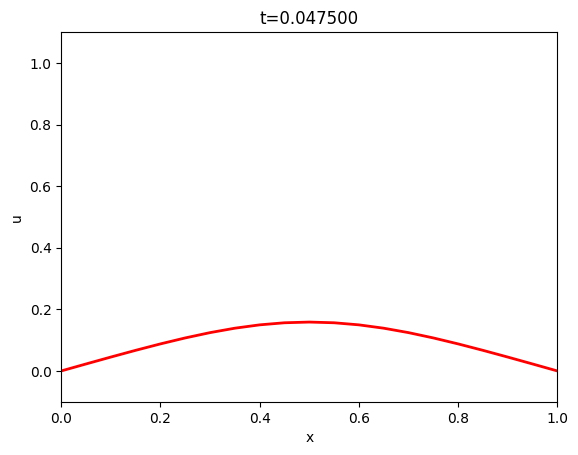

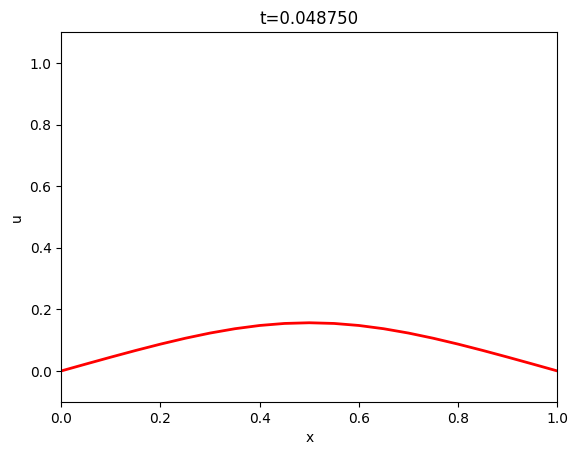

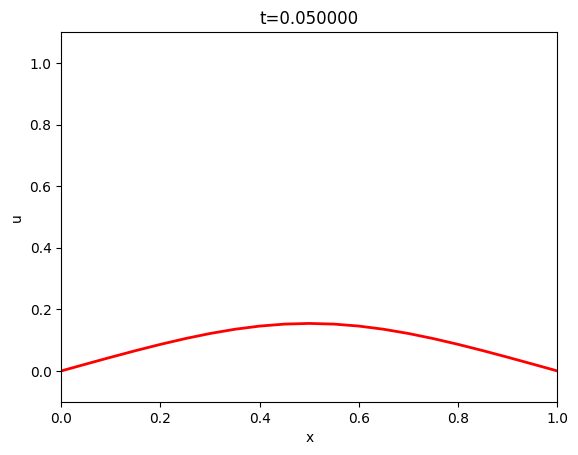

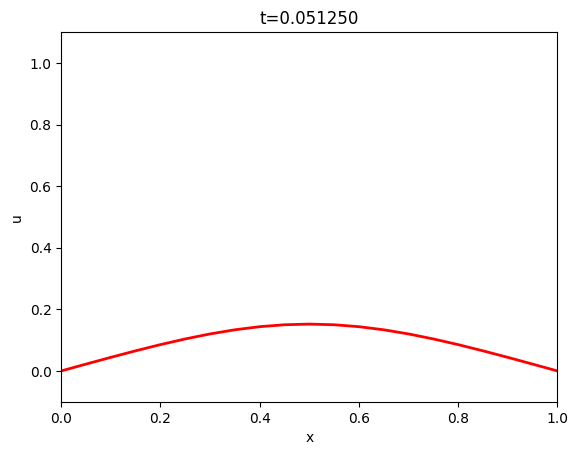

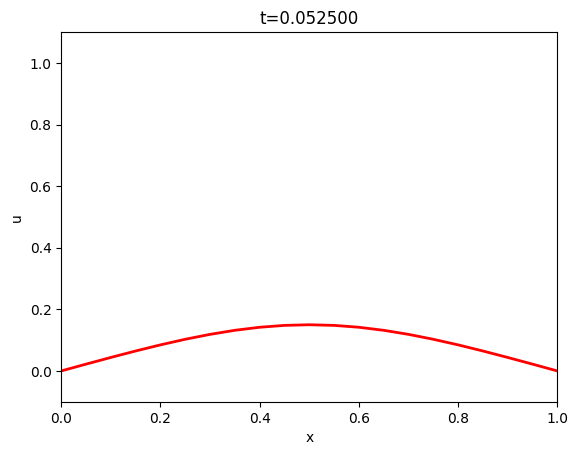

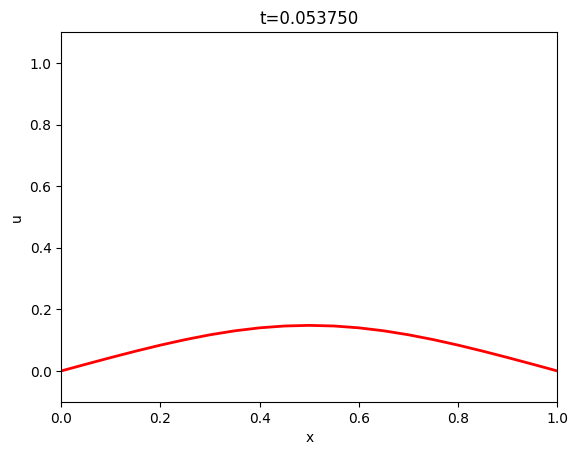

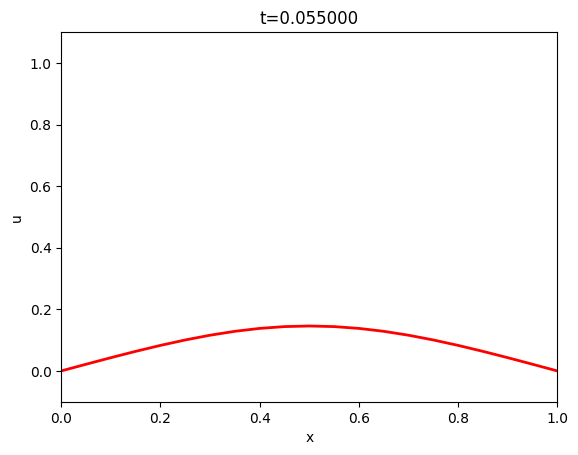

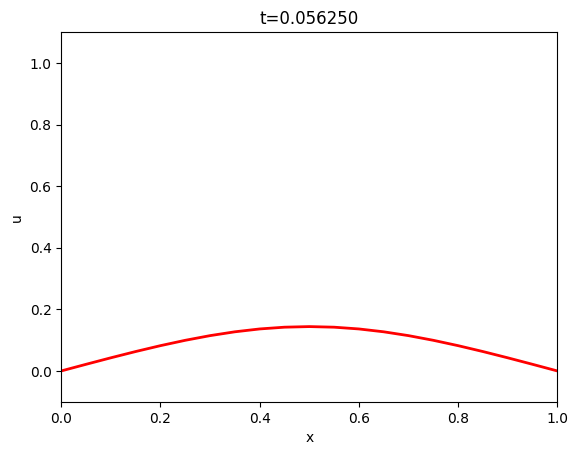

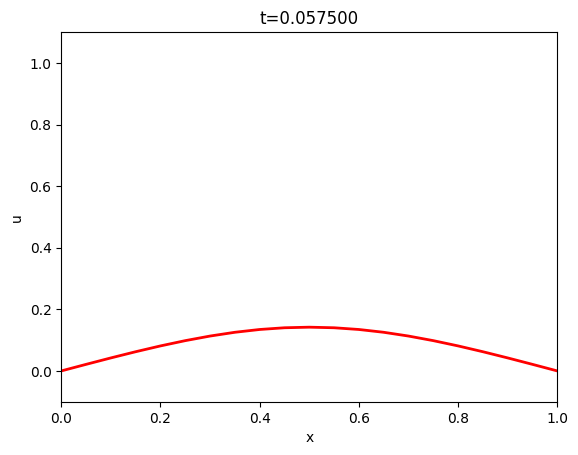

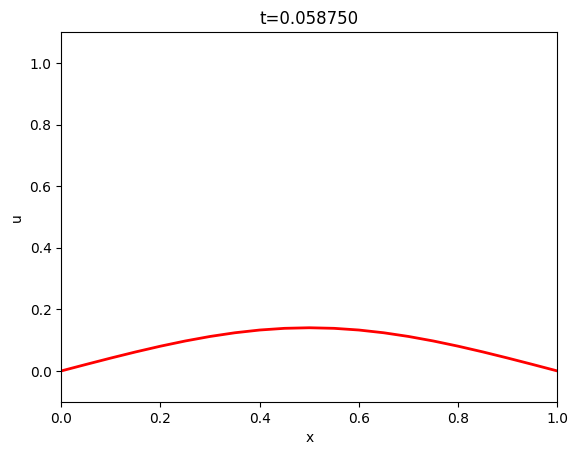

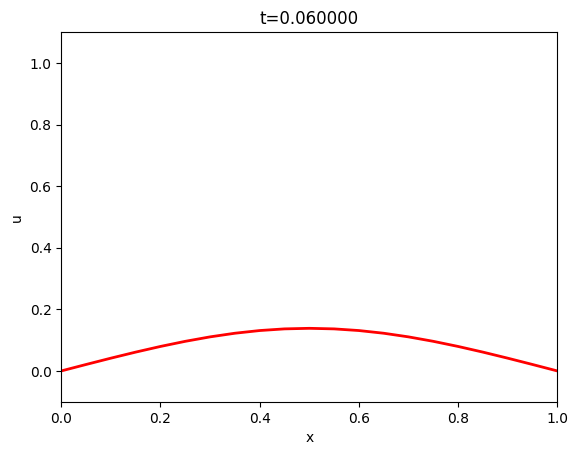

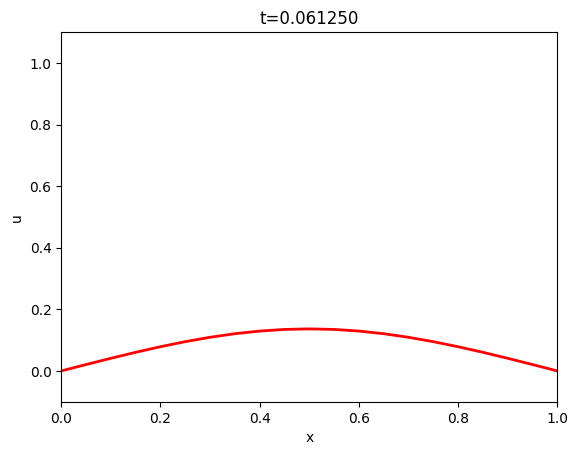

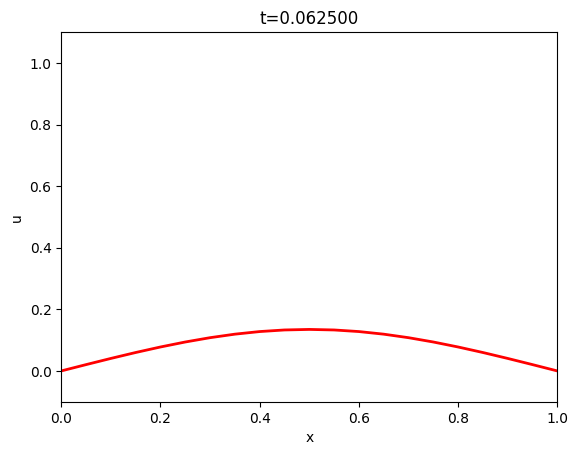

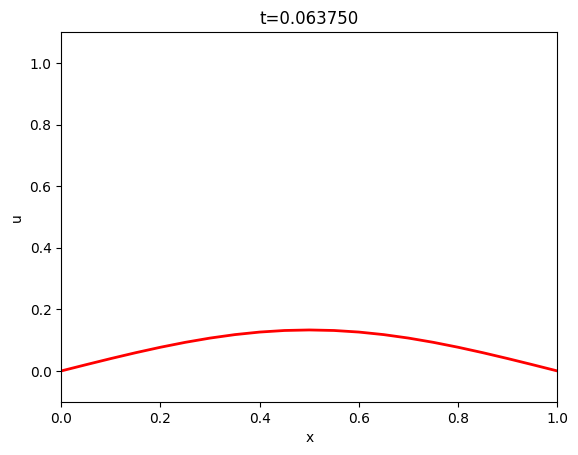

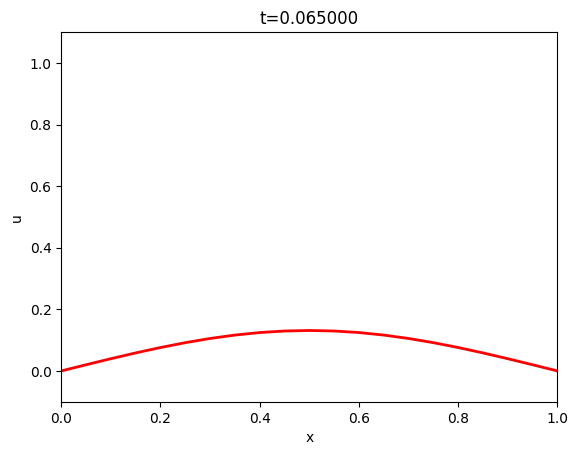

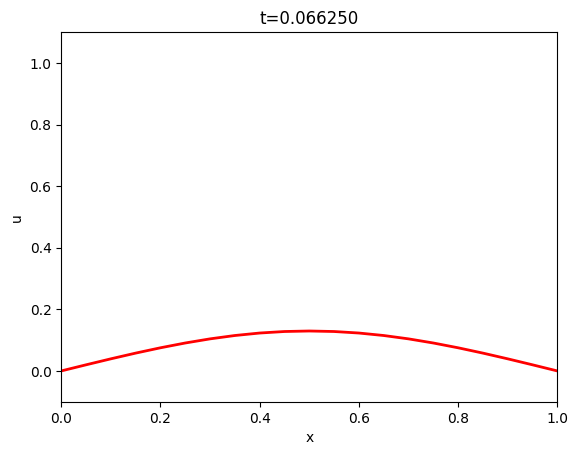

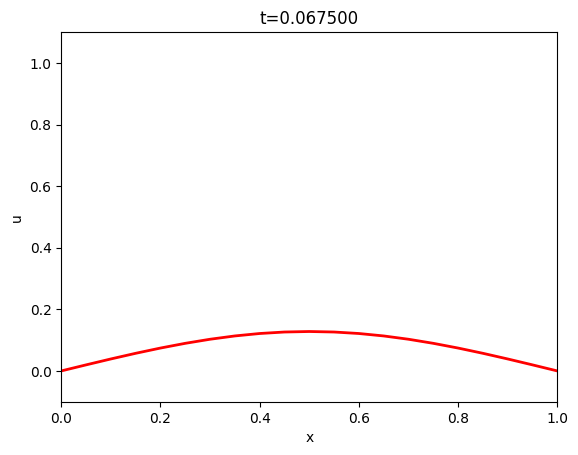

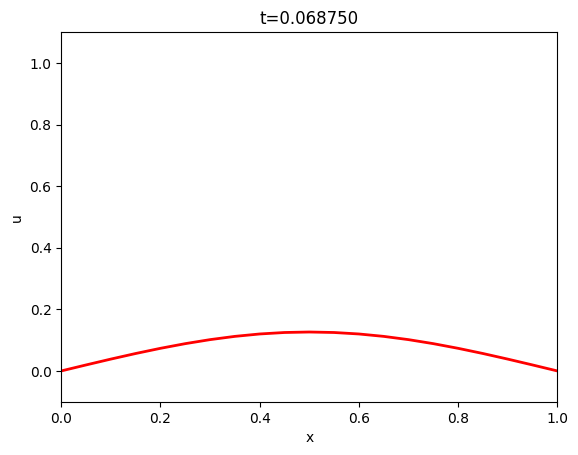

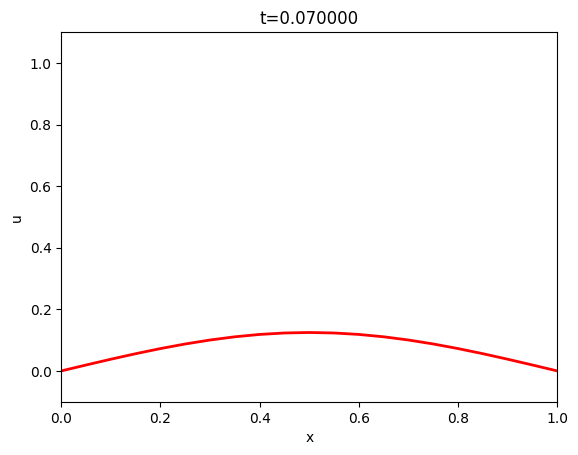

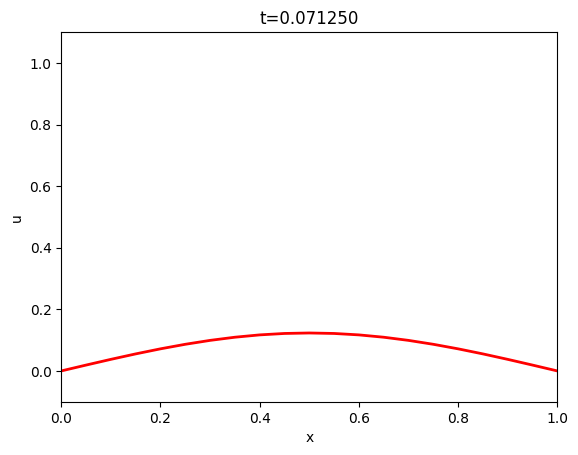

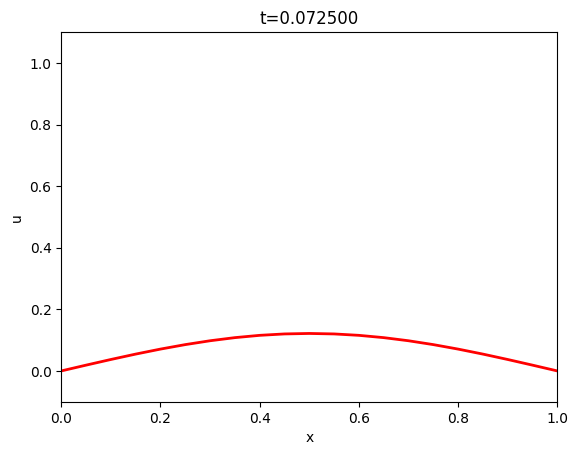

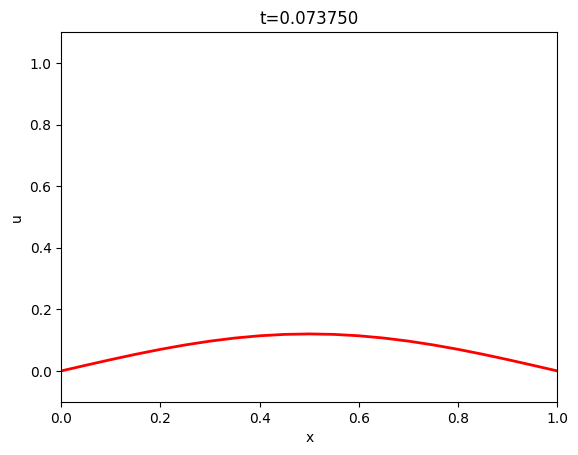

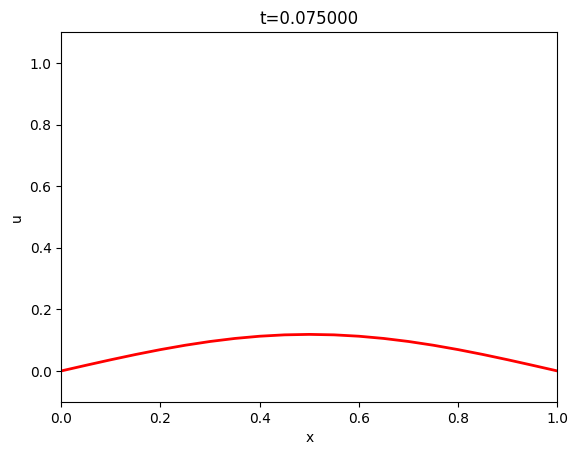

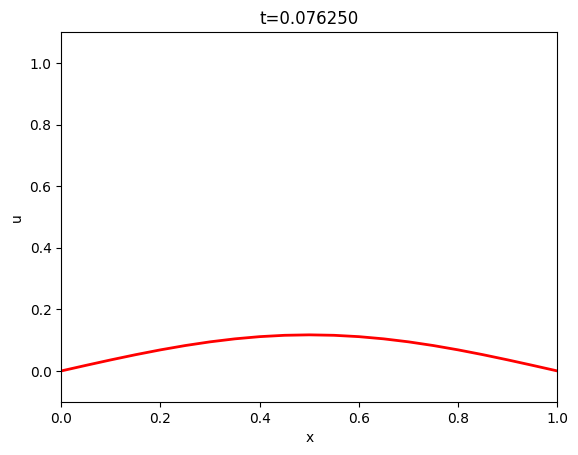

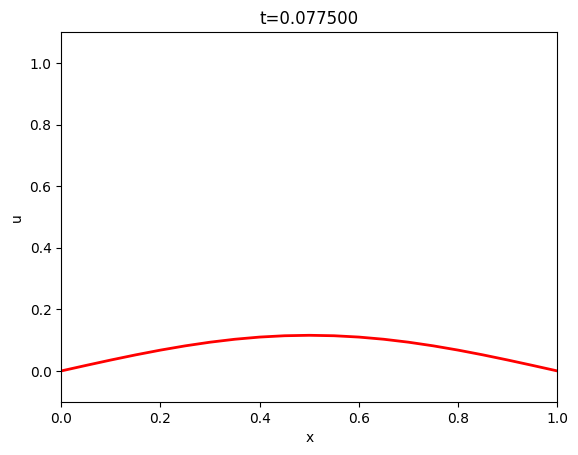

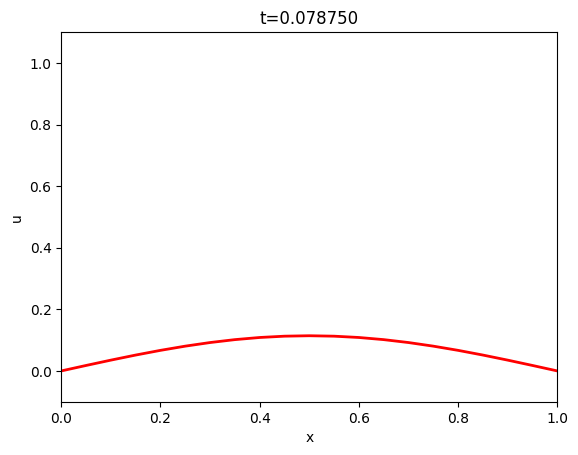

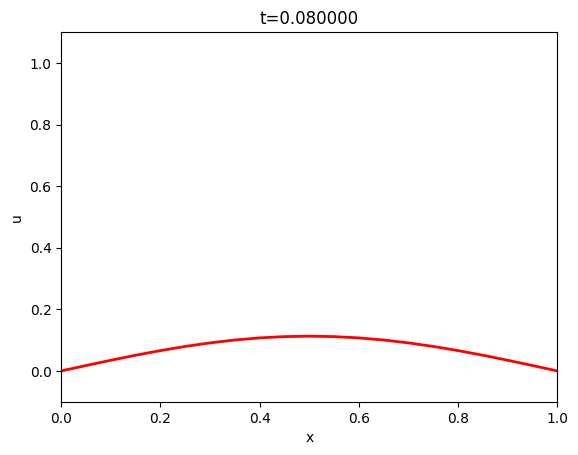

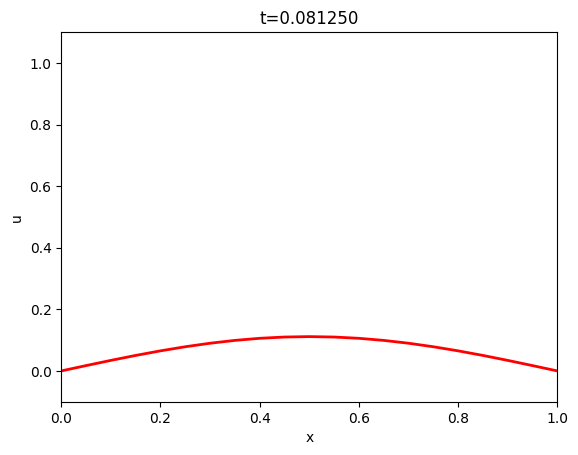

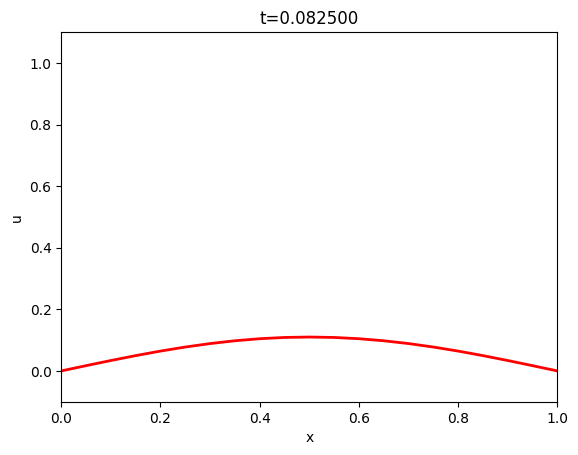

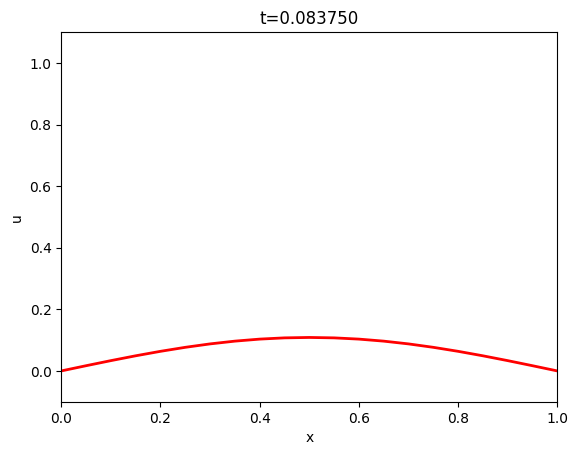

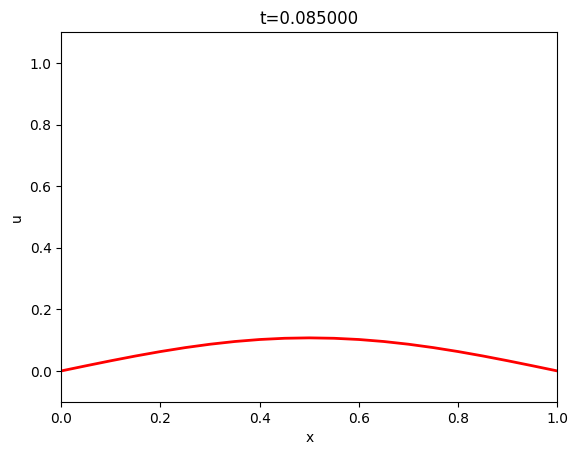

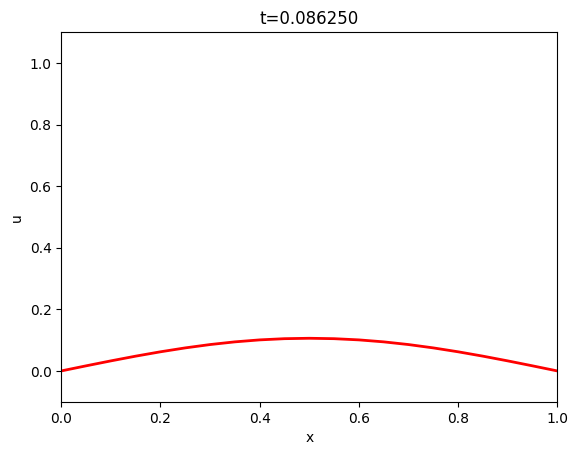

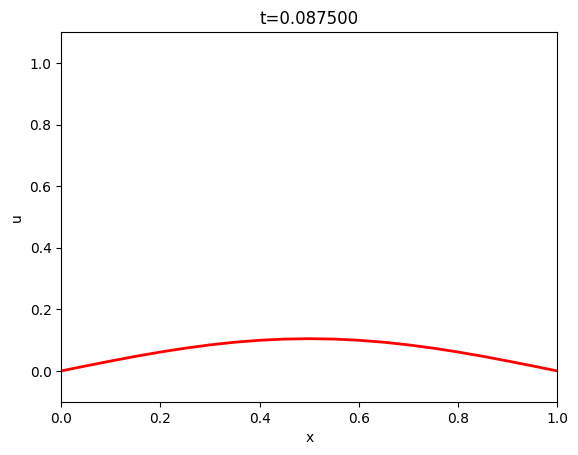

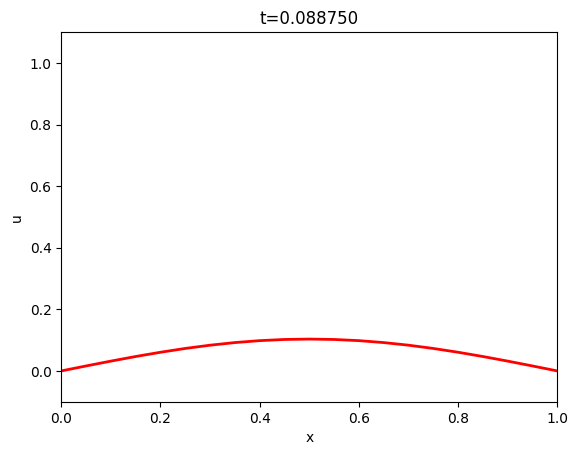

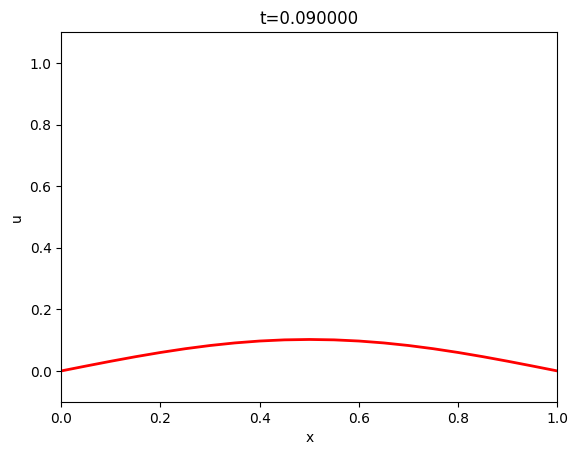

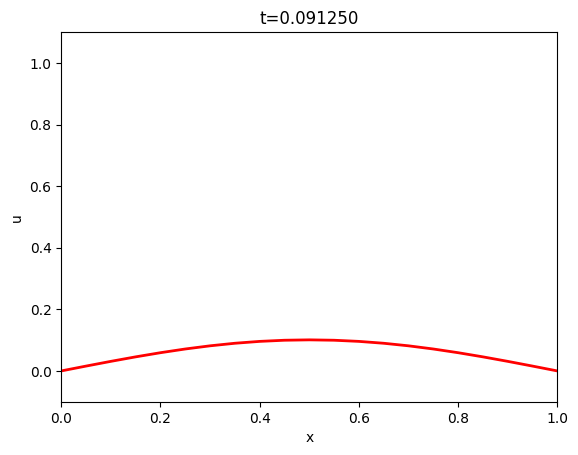

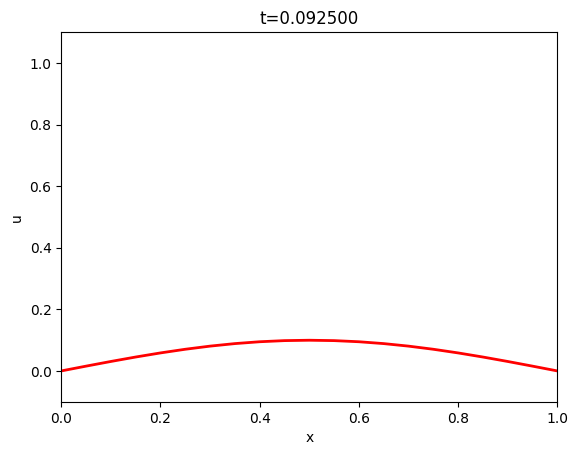

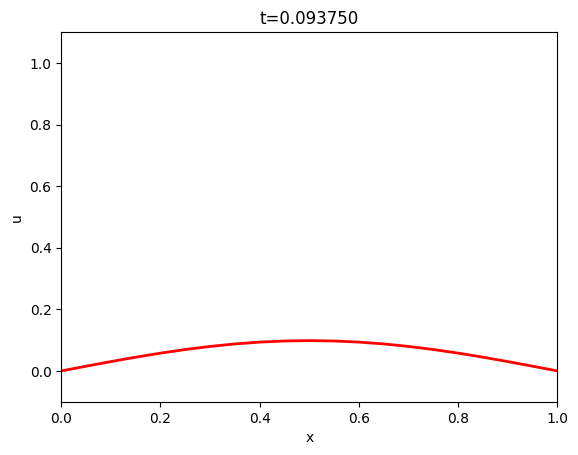

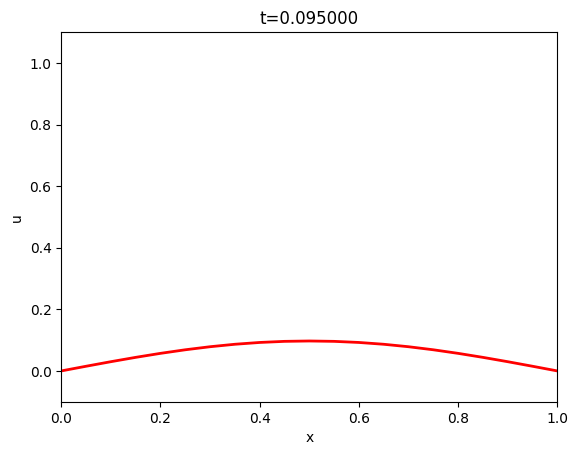

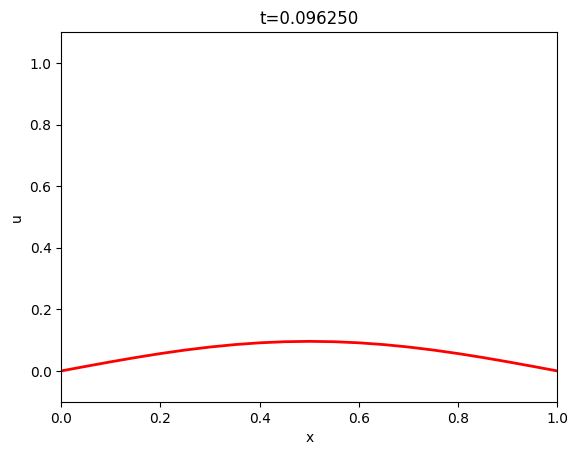

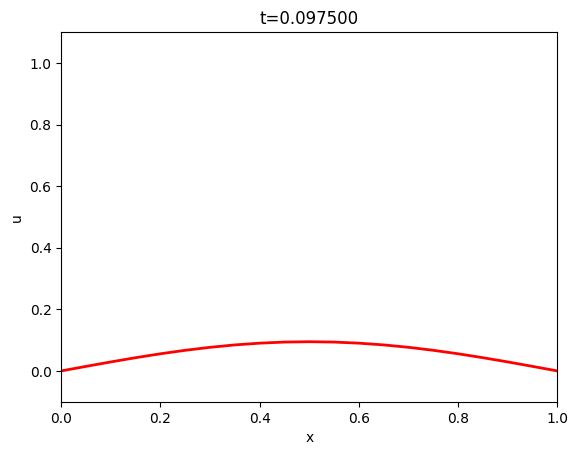

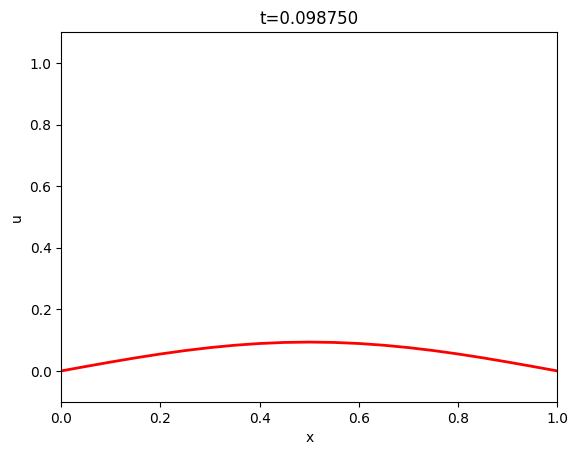

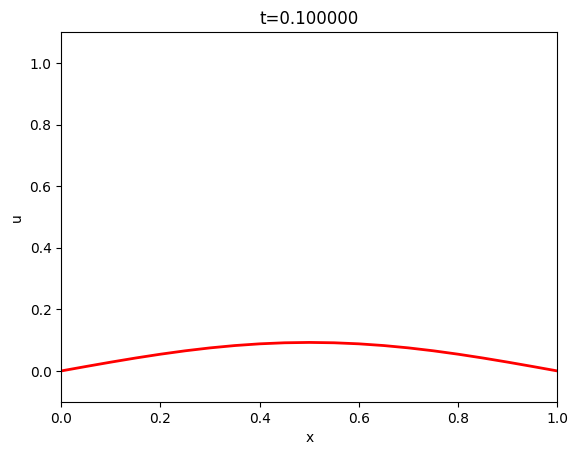

<Figure size 640x480 with 0 Axes>

In [25]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg

def solver_theta(I, a, f, L, dt, F, T, theta=0.5, u_L=0, u_R=0,
                 user_action=None):
    """
    Full solver for the model problem using the theta-rule
    difference approximation in time (no restriction on F,
    i.e., the time step when theta >= 0.5).
    Vectorized implementation and sparse (tridiagonal)
    coefficient matrix.
    """
    t0 = time.process_time()  # for measuring the CPU time

    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u   = np.zeros(Nx+1)   # solution array at t[n+1]
    u_n = np.zeros(Nx+1)   # solution at t[n]

    # Representation of sparse matrix and right-hand side
    diagonal = np.zeros(Nx+1)
    lower    = np.zeros(Nx)
    upper    = np.zeros(Nx)
    b        = np.zeros(Nx+1)

    # Precompute sparse matrix (scipy format)
    Fl = F*theta
    Fr = F*(1-theta)
    diagonal[:] = 1 + 2*Fl
    lower[:] = -Fl
    upper[:] = -Fl
    # Insert boundary conditions
    diagonal[0] = 1
    upper[0] = 0
    diagonal[Nx] = 1
    lower[-1] = 0

    diags = [0, -1, 1]
    A = scipy.sparse.diags(
        diagonals=[diagonal, lower, upper],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')

    # Set initial condition
    for i in range(0,Nx+1):
        u_n[i] = I(x[i])

    if user_action is not None:
        user_action(u_n, x, t, 0)

    # Time loop
    for n in range(0, Nt):
        b[1:-1] = u_n[1:-1] + \
                  Fr*(u_n[:-2] - 2*u_n[1:-1] + u_n[2:]) + \
                  dt*theta*f(x[1:-1], t[n+1]) + \
                  dt*(1-theta)*f(x[1:-1], t[n])
        b[0] = u_L; b[-1] = u_R  # boundary conditions
        u[:] = scipy.sparse.linalg.spsolve(A, b)

        if user_action is not None:
            user_action(u, x, t, n+1)

        # Update u_n before next step
        u_n, u = u, u_n

    t1 = time.process_time()
    cpu_time = t1 - t0
    return u, x, t, cpu_time  # Return the solution and CPU time


def viz(I, a, L, dt, F, T, umin, umax,
        scheme='FE', save_pdf=True, pdf_filename='output.pdf'):

    def plot_u(u, x, t, n):
        plt.plot(x, u, 'r-', linewidth=2)
        plt.axis([0, L, umin, umax])
        plt.title('t=%f' % t[n])
        plt.xlabel('x')
        plt.ylabel('u')
        plt.draw()  # Draw the plot
        plt.pause(0.01)  # Pause to display the plot
        plt.savefig(pdf_filename, format='pdf')  # Save plot as PDF
        plt.clf()  # Clear the current figure for the next plot

    user_action = plot_u

    cpu = eval('solver_' + scheme)(I, a, lambda x, t: 0, L, dt, F, T,
                                   user_action=user_action)

    return cpu


def plug(scheme='FE', F=0.5, Nx=50):
    L = 1.
    a = 1.
    T = 0.1
    # Compute dt from Nx and F
    dx = L/Nx;  dt = F/a*dx**2

    def I(x):
        """Plug profile as initial condition."""
        if abs(x-L/2.0) > 0.1:
            return 0
        else:
            return 1

    cpu = viz(I, a, L, dt, F, T,
              umin=-0.1, umax=1.1,
              scheme=scheme, save_pdf=True, pdf_filename='plug_output.pdf')
    # print('CPU time:', cpu)


def gaussian(scheme='FE', F=0.5, Nx=50, sigma=0.05):
    L = 1.
    a = 1.
    T = 0.1
    # Compute dt from Nx and F
    dx = L/Nx;  dt = F/a*dx**2

    def I(x):
        """Gaussian profile as initial condition."""
        return np.exp(-0.5*((x-L/2.0)**2)/sigma**2)

    cpu = viz(I, a, L, dt, F, T,
              umin=-0.1, umax=1.1,
              scheme=scheme, save_pdf=True, pdf_filename='gaussian_output.pdf')
    # print('CPU time:', cpu)


def test_solvers():
    def u_exact(x, t):
        return x*(L-x)*5*t  # fulfills BC at x=0 and x=L

    def I(x):
        return u_exact(x, 0)

    def f(x, t):
        return 5*x*(L-x) + 10*a*t

    a = 3.5
    L = 1.5
    Nx = 50
    F = 0.5
    # Compute dt from Nx and F
    dx = L/Nx
    dt = F/a*dx**2

    def compare(u, x, t, n):      # user_action function
        """Compare exact and computed solution."""
        u_e = u_exact(x, t[n])
        diff = np.abs(u_e - u).max()
        tol = 1E-10
        assert diff < tol, 'max diff: %g' % diff

    import functools
    s = functools.partial  # object for calling a function w/args
    solvers = [
       s(solver_theta,     I=I, a=a, f=f, L=L, dt=dt, F=F, T=2,
          theta=0, u_L=0, u_R=0, user_action=compare),
        ]
    # solver_FE_simple has different return from the others
    u, x, t, cpu = solvers[0]()
    u_e = u_exact(x, t[-1])
    diff = np.abs(u_e - u).max()
    tol = 1E-3
    print("Printing the exact solution of the diffusion equation")
    print(u_e)
    print("*****************************************************")
    print("Printing the constructed numerical solution of the diffusion equation")
    print(u)
    print("*****************************************************")
    assert diff < tol, 'max diff solver_theta: %g' % diff

    print("Exact and numerical solutions are in the tolerance level",tol)

    for solver in solvers:
        solver()


test_solvers()
print("For plug input")
plug(scheme='theta', F=0.5, Nx=20)

print('')
print("************************")
print("------------------------")
print("************************")
print('')

print("For Gaussian input")
gaussian(scheme='theta', F=0.5, Nx=20, sigma=0.05)
